In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [2]:
# =========================
# ⚙️ Standard Libraries
# =========================
import math
import warnings

# =========================
# 📊 Data Manipulation
# =========================
import numpy as np
import pandas as pd

# =========================
# 📈 Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Set seaborn style globally
sns.set(style="whitegrid", font_scale=1.1)

# =========================
# 🧪 Scientific Computing
# =========================
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import boxcox
from scipy.stats import ks_2samp

# =========================
# 🤖 Machine Learning - Core
# =========================
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# =========================
# 🤖 Machine Learning - Models
# =========================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    IsolationForest,
    VotingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans,AgglomerativeClustering

# =========================
# 📊 Evaluation Metrics
# =========================
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    silhouette_score
)

# =========================
# ⚠️ Warning Handling
# =========================
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

In [3]:
# Load the datasets
train_df = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

# 🧪 Exploratory Data Analysis (EDA)

Before diving into modeling, we begin by exploring the dataset to understand its structure, feature distributions, relationships, and potential seasonal or non-linear patterns.

The goal is to uncover useful insights, detect anomalies, and guide preprocessing or feature engineering strategies.

In [4]:
# Check data types and missing values
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.5 KB
None


## 📊 Dataset Overview

- **Shape**: 2,190 rows × 13 columns  
- **Size**: ~222 KB  
- **No missing values** ✅  
- **Feature types**:
  - 10 numerical (`float64`)
  - 3 categorical/integer (`int64`): `id`, `day`, `rainfall`  
- **Target**: `rainfall` (binary classification)

🧼 Dataset is clean and fully ready for analysis or modeling.


In [5]:
# Save 'id' column for submission
test_ids = test_df['id']

# Define the target column
target_column = "rainfall"

# Select categorical and numerical columns (initial)
numerical_columns = [col for col in train_df.columns if col != "rainfall"]

# Print out column information
print("Target Column:", target_column)
print("\nNumerical Columns:", numerical_columns)

Target Column: rainfall

Numerical Columns: ['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']


In [6]:
# Check dataset shape and first rows
print(f"Dataset contains {train_df.shape[0]} rows and {train_df.shape[1]} columns.")
train_df.head()

Dataset contains 2190 rows and 13 columns.


id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
0   0    1    1017.4     21.2         20.6     19.9      19.4      87.0   
1   1    2    1019.5     16.2         16.9     15.8      15.4      95.0   
2   2    3    1024.1     19.4         16.1     14.6       9.3      75.0   
3   3    4    1013.4     18.1         17.8     16.9      16.8      95.0   
4   4    5    1021.8     21.3         18.4     15.2       9.6      52.0   

   cloud  sunshine  winddirection  windspeed  rainfall  
0   88.0       1.1           60.0       17.2         1  
1   91.0       0.0           50.0       21.9         1  
2   47.0       8.3           70.0       18.1         1  
3   95.0       0.0           60.0       35.6         1  
4   45.0       3.6           40.0       24.8         0

In [7]:
# Get statistical summary
train_df.describe()

id          day     pressure      maxtemp  temparature  \
count  2190.000000  2190.000000  2190.000000  2190.000000  2190.000000   
mean   1094.500000   179.948402  1013.602146    26.365799    23.953059   
std     632.342866   105.203592     5.655366     5.654330     5.222410   
min       0.000000     1.000000   999.000000    10.400000     7.400000   
25%     547.250000    89.000000  1008.600000    21.300000    19.300000   
50%    1094.500000   178.500000  1013.000000    27.800000    25.500000   
75%    1641.750000   270.000000  1017.775000    31.200000    28.400000   
max    2189.000000   365.000000  1034.600000    36.000000    31.500000   

           mintemp     dewpoint     humidity        cloud     sunshine  \
count  2190.000000  2190.000000  2190.000000  2190.000000  2190.000000   
mean     22.170091    20.454566    82.036530    75.721918     3.744429   
std       5.059120     5.288406     7.800654    18.026498     3.626327   
min       4.000000    -0.300000    39.000000     2.000000     0.000000   
25%      17.700000    16.800000    77.000000    69.000000     0.400000   
50%      23.850000    22.150000    82.000000    83.000000     2.400000   
75%      26.400000    25.000000    88.000000    88.000000     6.800000   
max      29.800000    26.700000    98.000000   100.000000    12.100000   

       winddirection    windspeed     rainfall  
count    2190.000000  2190.000000  2190.000000  
mean      104.863151    21.804703     0.753425  
std        80.002416     9.898659     0.431116  
min        10.000000     4.400000     0.000000  
25%        40.000000    14.125000     1.000000  
50%        70.000000    20.500000     1.000000  
75%       200.000000    27.900000     1.000000  
max       300.000000    59.500000     1.000000

In [8]:
# Compute summary stats
skew_values = train_df[numerical_columns].skew(numeric_only=True)
mean_values = train_df[numerical_columns].mean(numeric_only=True)
std_values = train_df[numerical_columns].std(numeric_only=True)

# Create DataFrame
stat_df = pd.DataFrame({
    'Feature': skew_values.index,
    'Mean': mean_values.values.round(3),
    'Std Dev': std_values.values.round(3),
    'Skewness': skew_values.values.round(3)
}).sort_values(by='Mean', key=abs, ascending=False).reset_index(drop=True)

# Color rules
def highlight_stats(val, column):
    if column == 'Skewness' and abs(val) > 1:
        return 'color: red; font-weight: bold'
    if column == 'Std Dev' and val > stat_df['Std Dev'].median() + stat_df['Std Dev'].std():
        return 'color: orange; font-weight: bold'
    if column == 'Mean' and val > stat_df['Mean'].median() + stat_df['Mean'].std():
        return 'color: blue; font-weight: bold'
    return ''

# Apply styling
def highlight_df(df):
    styled_df = df.style.applymap(lambda v: highlight_stats(v, 'Mean'), subset=['Mean']) \
                        .applymap(lambda v: highlight_stats(v, 'Std Dev'), subset=['Std Dev']) \
                        .applymap(lambda v: highlight_stats(v, 'Skewness'), subset=['Skewness']) \
                        .set_properties(**{'background-color': 'white'}, subset=pd.IndexSlice[:, :]) \
                        .set_table_styles([{'selector': 'th', 'props': [('background-color', '#afe1f0'), ('font-weight', 'bold')]}])
    return styled_df

# Display
highlight_df(stat_df)

## 📈 Descriptive Statistics

- All variables are on **consistent physical scales** (°C, %, hPa, km/h...) and show realistic min/max values.
- No outliers detected visually, but skewness helps refine this.

---

### 🔍 Key Insights:

- **`cloud`**: Most skewed variable (skewness = -1.34) → many fully overcast days.
- **`dewpoint`**, `humidity`, `windspeed` and `winddirection` also show moderate skewness → consider transformation.
- **Temperature trio (`maxtemp`, `temperature`, `mintemp`)** are well centered and tightly distributed — no strong asymmetry.
- **`sunshine`** is low on average (mean = 3.74h) and right-skewed → few very sunny days.

---

### 📌 Conclusion

- Data distributions are generally clean and symmetric.
- A few variables (notably `cloud`, `dewpoint`, `windspeed`) may benefit from transformation for modeling.
- Overall: suitable for standard scaling, PCA, and clustering without major preprocessing.

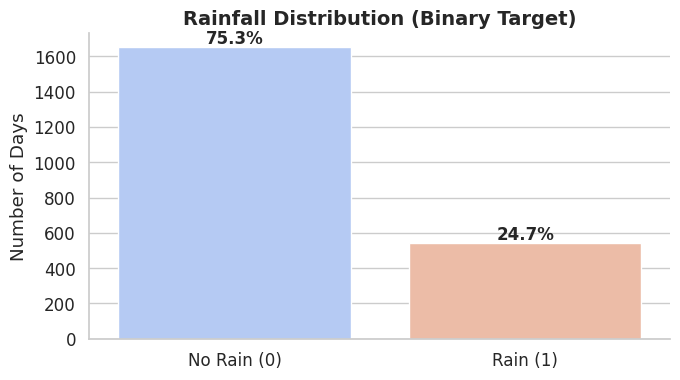

In [9]:
# Target variable distribution
target_counts = train_df[target_column].value_counts()
labels = ['No Rain (0)', 'Rain (1)']
counts = target_counts.values
total = counts.sum()
ratios = [f'{(count / total) * 100:.1f}%' for count in counts]

# Car counter-style visualization
plt.figure(figsize=(7, 4))
bars = sns.barplot(x=labels, y=counts, palette="coolwarm")

# Annotate percentage above each bar
for bar, ratio in zip(bars.patches, ratios):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 20,
             ratio, ha='center', fontsize=12, fontweight='bold')

plt.title('Rainfall Distribution (Binary Target)', fontsize=14, weight='bold')
plt.ylabel('Number of Days')
plt.xlabel('')
sns.despine()
plt.tight_layout()
plt.show()

## 🧭 Target Distribution Analysis & Implications

- The dataset is **imbalanced**, with **~75% of days labeled as 'No Rain'** and only **~25% as 'Rain'**.
- This imbalance means that naive models predicting only the majority class (no rain) could achieve high accuracy **without being truly useful**.
- As a result, **accuracy is not a reliable evaluation metric** here.

👉 **Recommended metrics** for evaluating model performance:
- **ROC AUC**: Measures the ability to distinguish between classes across thresholds.
- **Precision / Recall / F1-Score**: Especially important for the minority class (`Rain`), depending on whether we want to reduce false negatives (recall) or false positives (precision).
- **Confusion Matrix**: Helps visualize prediction balance.

> 💡 Handling the imbalance may require resampling techniques or cost-sensitive learning strategies depending on model performance.


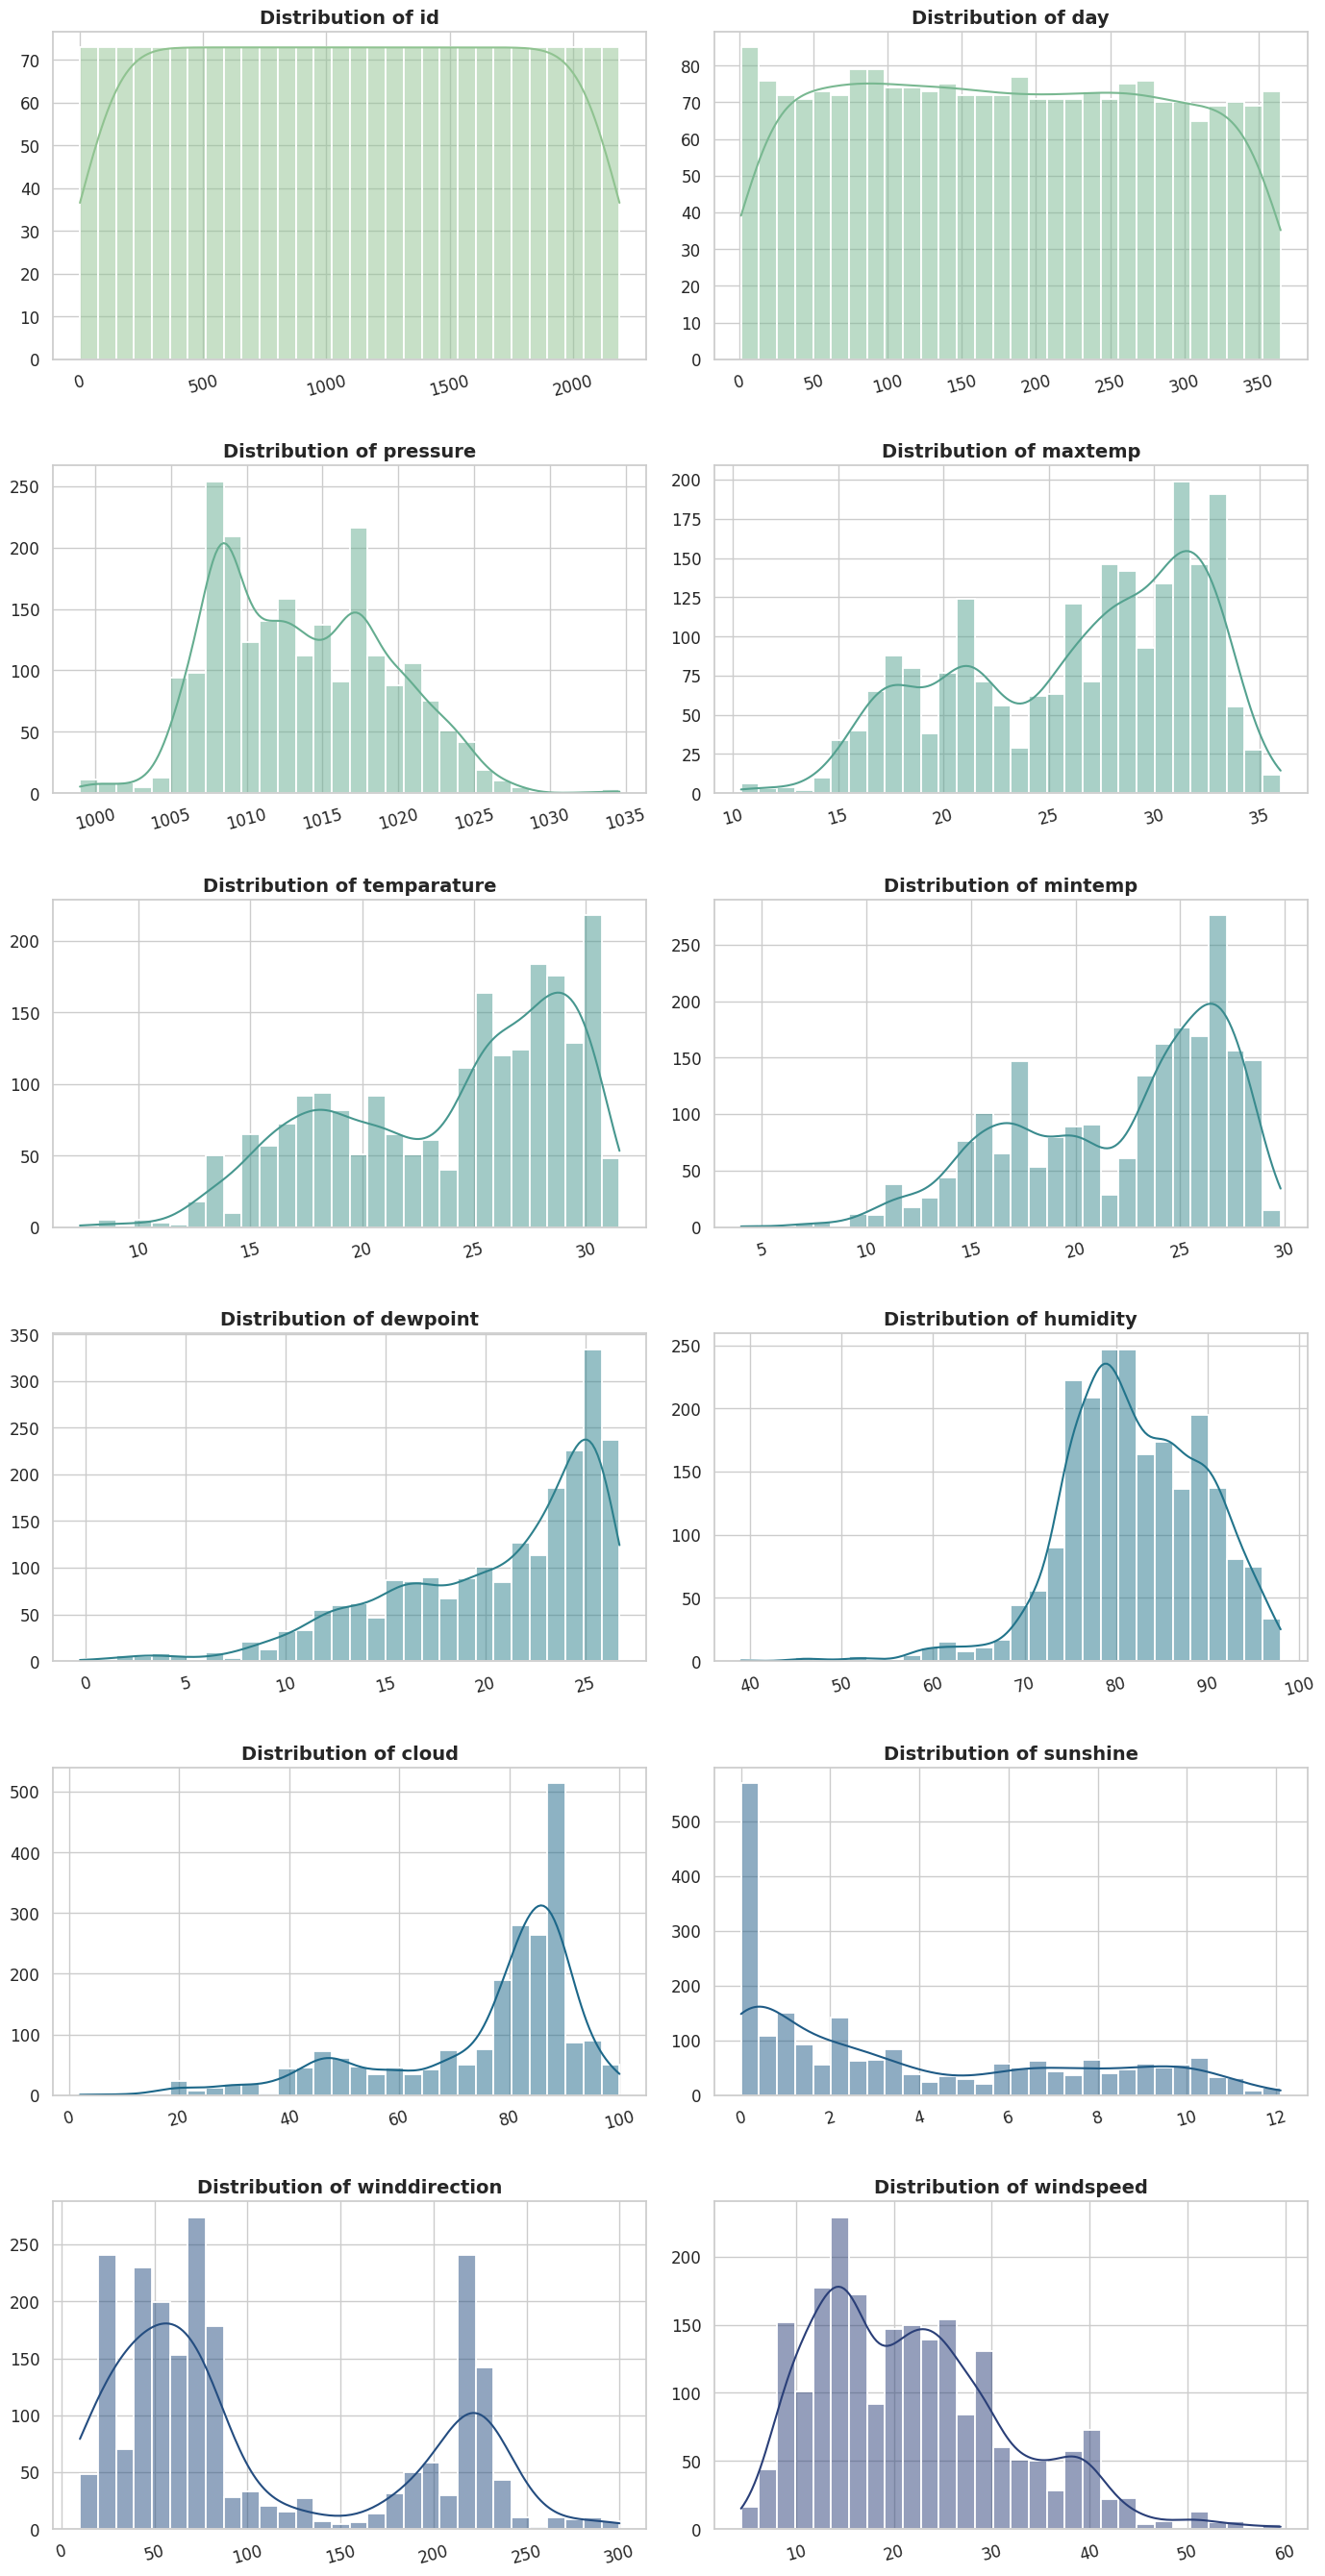

In [10]:
# Dynamically calculate number of rows & columns
num_vars = len(numerical_columns)
num_cols = 2  # Keep 2 columns for readability
num_rows = math.ceil(num_vars / num_cols)  # Calculate rows dynamically

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, num_rows * 4.5))
axes = axes.flatten()

# Color palette (color-blind friendly)
palette = sns.color_palette("crest", n_colors=num_vars)

# Plotting each variable
for i, var in enumerate(numerical_columns):
    sns.histplot(
        data=train_df,
        x=var,
        kde=True,
        color=palette[i],
        bins=30,
        edgecolor="white",
        linewidth=1.3,
        ax=axes[i]
    )
    axes[i].set_title(f"Distribution of {var}", fontsize=14, weight="bold")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].tick_params(axis='x', labelrotation=15)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout(h_pad=2.5)
plt.show()

## 📊 Feature Distributions — Weather Variables

---

### 🌡️ Temperature-related variables:
- `maxtemp`, `temperature`, `mintemp` all follow near-normal or slightly left-skewed distributions.
- `dewpoint` is right-skewed, with many values near the upper bound — typical for humid climates.

### 🌫️ Humidity and Cloud:
- `humidity` shows a bell shape with a slight right skew, concentrated around 75–90%.
- `cloud` is strongly right-skewed (peaked at 90–100%) → indicates many overcast days.

### 🌞 Sunshine:
- `sunshine` is highly right-skewed — many zero or low-sunlight days, followed by a long tail up to ~12 hours.
- Good candidate for transformation (e.g., log or square root).

### 🌬️ Wind:
- `windspeed` has a moderate right skew — most days have light to moderate wind, few strong.
- `winddirection` shows bimodal behavior with peaks around ~50° and ~220° → likely from two dominant wind regimes.

### 🌡️ Pressure:
- `pressure` is mildly right-skewed, centered around ~1013 hPa (standard atmospheric pressure).

---

### ✅ Conclusion:
- Most variables follow expected meteorological patterns.
- `cloud`, `sunshine`, `dewpoint`, and `windspeed` may benefit from transformation.
- `winddirection` is circular and would benefit from dedicated encoding.

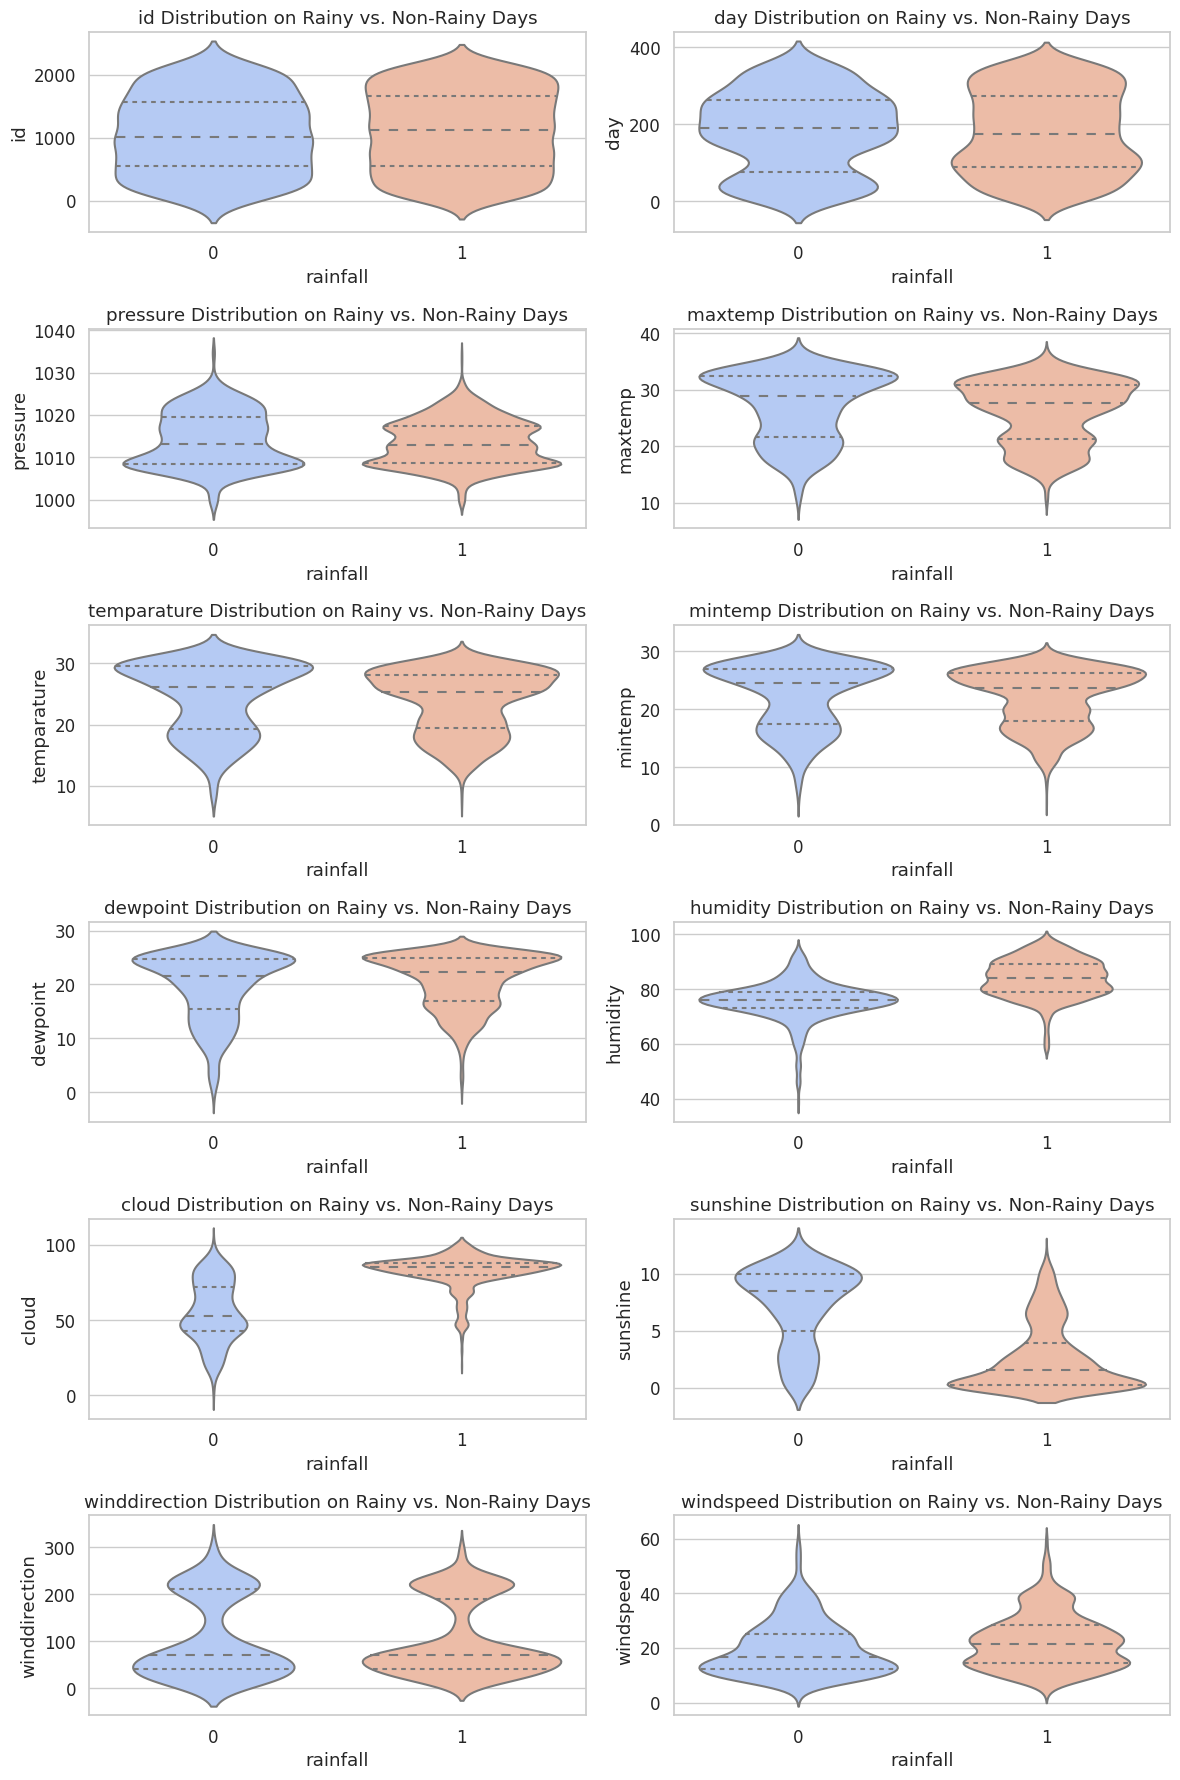

In [11]:
# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 18))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot violin plots
for i, var in enumerate(numerical_columns):
    sns.violinplot(x=train_df[target_column], y=train_df[var], palette="coolwarm", inner="quartile", ax=axes[i])
    axes[i].set_title(f"{var} Distribution on Rainy vs. Non-Rainy Days")

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  

plt.tight_layout()
plt.show()


## 🎯 Impact of Rainfall on Feature Distributions

Compared to previous global distributions, stratifying by `rainfall` highlights key contrasts:

- **`humidity`** and **`cloud`** are significantly higher on rainy days.
- **`windspeed`** shows a slight increase when it rains.
- **`sunshine`** (not shown here) is near-zero during rainfall, confirming its inverse correlation.
- **Temperature-related variables** (`maxtemp`, `mintemp`, `temperature`) show small drops on rainy days.
- **`pressure`** and **`winddirection`** show minor or unclear separation.

These insights reinforce that `humidity`, `cloud`, `sunshine` and `windspeed` are strong indicators of rainfall events.

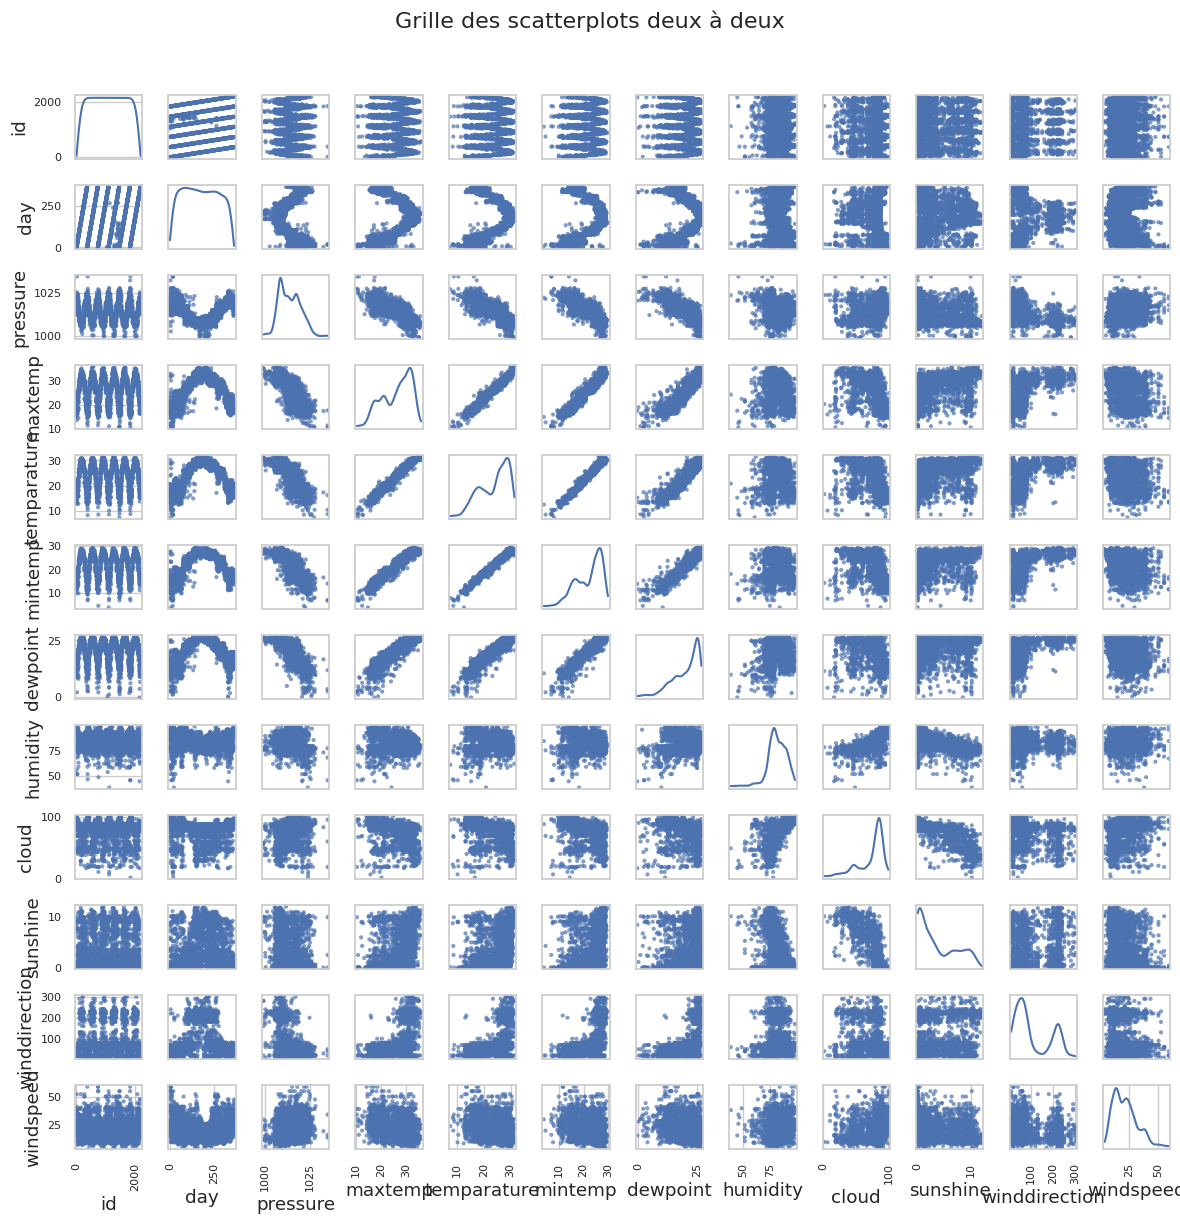

In [12]:
# Grille des scatterplots deux à deux pour visualiser les corrélations
pd.plotting.scatter_matrix(train_df[numerical_columns], figsize=(12, 12), diagonal='kde', alpha=0.7)

# Ajouter un titre général à la grille
plt.suptitle("Grille des scatterplots deux à deux", fontsize=16, y=1.02)

# Afficher le graphique
plt.tight_layout()
plt.show()

## 🔍 Pairplot Analysis — Numerical Feature Relationships

This pairplot provides a comprehensive view of the relationships and distributions between all numerical variables in the dataset.

---

#### 🧭 Key Observations:

- **Temperature-related variables**:
  - `maxtemp`, `temperature`, `mintemp`, and `dewpoint` are **strongly and linearly correlated**. These features are partially redundant, with `temperature` appearing as a midpoint between `maxtemp` and `mintemp`.
  - `dewpoint` is highly correlated with `temperature`, indicating it scales with thermal conditions.

- **Humidity & Cloud**:
  - `humidity` and `cloud` are moderately correlated, suggesting more humid days often have more cloud cover.
  - However, `humidity` shows more **non-linear** scatter with temperature-related features.

- **Sunshine**:
  - Inversely associated with `cloud` and `humidity`: clear anti-correlation, as expected.
  - Distributions are skewed toward high values (many sunny days) or very low (potential overcast blocks).

- **Pressure**:
  - Does **not correlate** linearly with most variables, but seems to follow **seasonal patterns** when plotted vs `day`.
  - Mild inverse pattern with `cloud`, suggesting that high-pressure systems are associated with clearer skies.

- **Wind features**:
  - `windspeed` has **low linear correlation** with other variables.
  - `winddirection` shows **circular pattern** (not linear), hard to interpret directly via scatterplot.

- **Day**:
  - Almost all variables exhibit **seasonal waves** when plotted against `day` — especially temperature, dewpoint, and pressure. This confirms the importance of **seasonal encoding** or clustering.


---
## 🧩 PCA Analysis on Weather Variables




In [13]:
df_eda = train_df.copy()
cols_to_use = [col for col in numerical_columns if col not in ['id', 'day']]

# Clean copy for analysis
X_eda = df_eda[cols_to_use]

# Standardize meteorological features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_eda)

# PCA on 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Insert PCA results into the copy
df_eda["PC1"] = X_pca[:, 0]
df_eda["PC2"] = X_pca[:, 1]

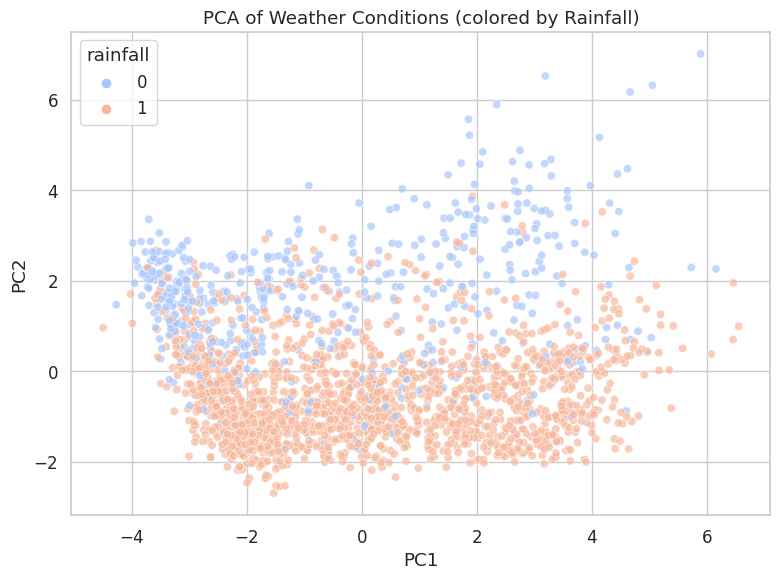

In [14]:
# Visualization in PCA space
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_eda, x="PC1", y="PC2", hue="rainfall", palette="coolwarm", alpha=0.7)
plt.title("PCA of Weather Conditions (colored by Rainfall)")
plt.grid(True)
plt.tight_layout()
plt.show()

### 📌 1. PCA Projection (colored by rainfall)

- The PCA projection shows a clear **separation** between rainy and dry days in the PC1/PC2 space.
- **Rainy days (1)** concentrate in the **lower half**, while **dry days (0)** dominate the upper part.
- This suggests that **rainfall can be partially explained** by a linear combination of weather features.

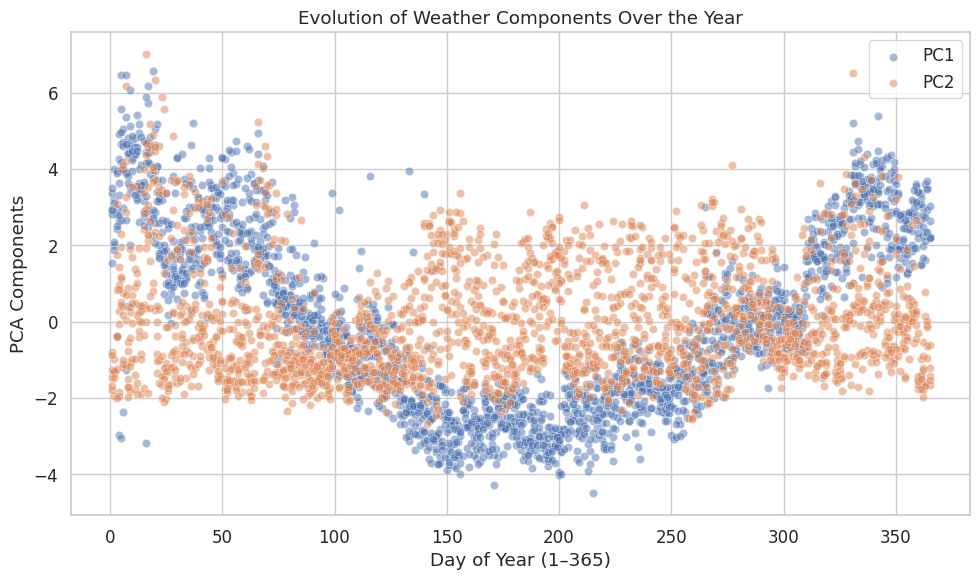

In [15]:
# Distribution of PCA components over the year
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_eda, x="day", y="PC1", alpha=0.5, label="PC1")
sns.scatterplot(data=df_eda, x="day", y="PC2", alpha=0.5, label="PC2")
plt.title("Evolution of Weather Components Over the Year")
plt.xlabel("Day of Year (1–365)")
plt.ylabel("PCA Components")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 📆 2. Seasonal Evolution of PCA Components

- Both principal components (PC1 and PC2) follow **strong seasonal patterns** across the year.
- **PC1** shows a sinusoidal pattern: **low in mid-year (summer)**, **high in winter**, aligned with typical temperature variation.
- **PC2** complements PC1, likely capturing cloud/humidity structure.
- The seasonality supports the use of PCA for capturing **temporal dynamics**.

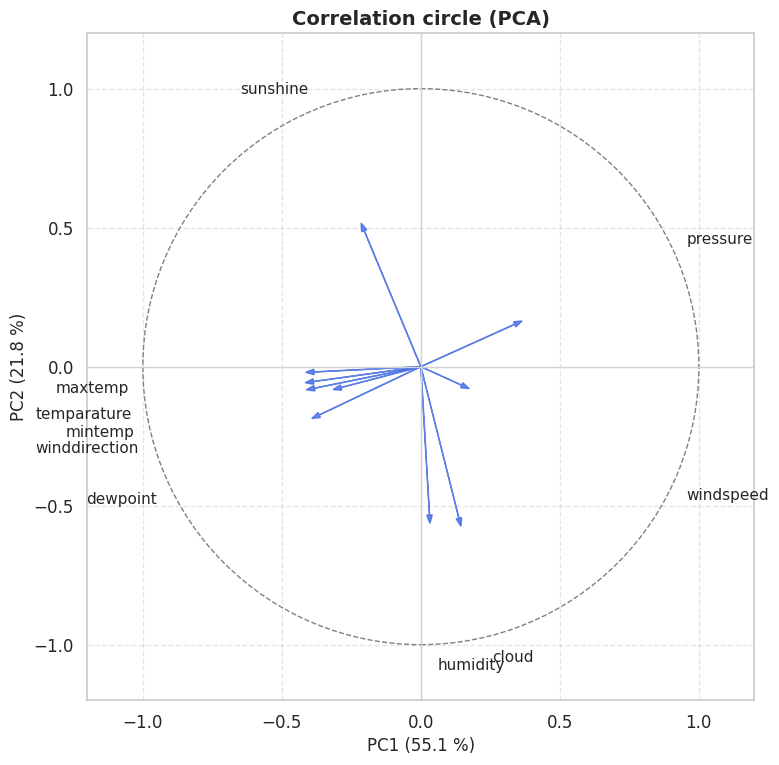

In [16]:
# Retrieve from previous PCA
components = pca.components_
explained_var = pca.explained_variance_ratio_
feature_names = cols_to_use

# Plot
plt.figure(figsize=(8, 8))
plt.axhline(0, color='lightgray', linewidth=1)
plt.axvline(0, color='lightgray', linewidth=1)

# Unit circle
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', linewidth=1)
plt.gca().add_artist(circle)

# Arrows and angle-based label positioning
for i, var in enumerate(feature_names):
    x, y = components[0, i], components[1, i]

    # Draw arrow
    plt.arrow(0, 0, x, y, color='royalblue', alpha=0.8, head_width=0.02, length_includes_head=True)

    # Compute angle to spread labels naturally
    angle = np.arctan2(y, x)
    radius = 1.05  # label distance

    label_x = radius * np.cos(angle)
    label_y = radius * np.sin(angle)

    align_h = 'left' if label_x > 0 else 'right'
    align_v = 'bottom' if label_y > 0 else 'top'

    plt.text(label_x, label_y, var, fontsize=11, ha=align_h, va=align_v)

# Layout
plt.xlabel(f"PC1 ({explained_var[0]*100:.1f} %)", fontsize=12)
plt.ylabel(f"PC2 ({explained_var[1]*100:.1f} %)", fontsize=12)
plt.title("Correlation circle (PCA)", fontsize=14, weight='bold')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 🧭 3. Correlation Circle (PCA)

- **PC1 (55%)** is mostly influenced by **temperature variables** (maxtemp, mintemp, dewpoint), in opposition to **humidity** and **cloud**.
- **PC2 (21.8%)** is more linked to **sunshine**, and orthogonal to temperature.
- This means:
  - PC1 ≈ hot vs humid/cloudy opposition
  - PC2 ≈ sunshine vs pressure structure

---

### ✅ Conclusion

- PCA provides a compact, interpretable representation of weather dynamics.
- The projection space is partially **separable for rainfall**, opening the door to dimensionality reduction in classification tasks.
- Seasonal information is **well captured**, justifying the integration of PCA components as temporal meta-features.
- The **correlation circle** gives strong intuition about the underlying meteorological structure, particularly opposing hot/sunny vs cloudy/humid regimes.


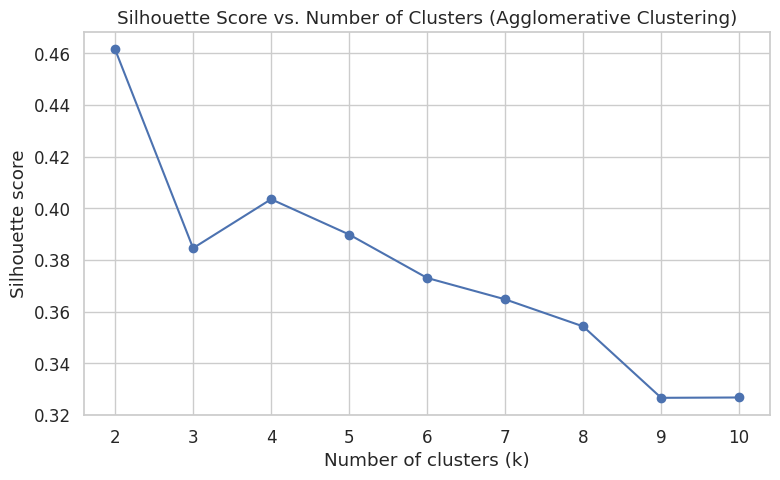

In [17]:
# Data from PCA
X_pca = df_eda[["PC1", "PC2"]].values

# Range of clusters
k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    clustering = AgglomerativeClustering(n_clusters=k)
    labels = clustering.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Score vs. Number of Clusters (Agglomerative Clustering)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.tight_layout()
plt.show()


### 🧠 Silhouette Score Interpretation

| k  | Silhouette Score | Interpretation                                     |
|----|------------------|----------------------------------------------------|
| 2  | ~0.47       | Highest score – likely best overall separation   |
| 3  | ~0.41           | Sudden drop – less compact                         |
| 4  | ~0.42 ✅          | Slight rebound – maybe some substructure           |
| ≥5 | progressively lower | Adding more clusters splits coherent groups     |


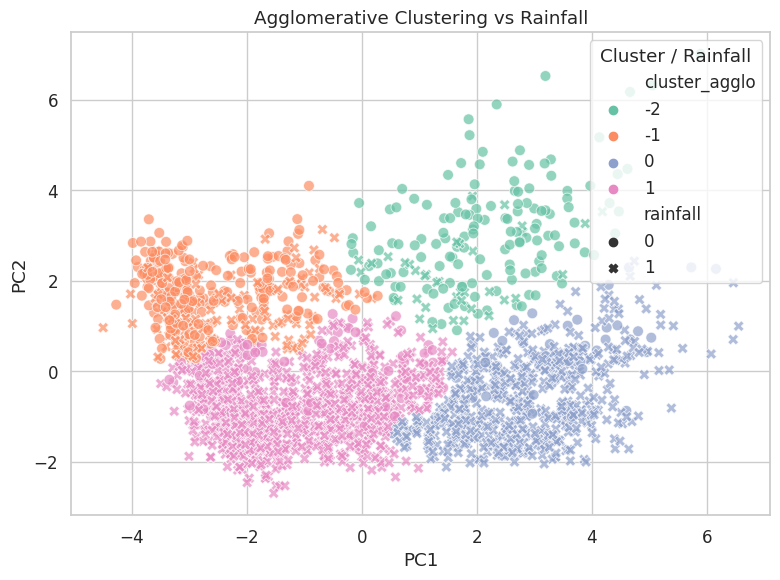

 Agglomerative Clustering - Accuracy: 0.4438
 Agglomerative Clustering - ROC AUC: 0.8046


In [18]:
from sklearn.cluster import AgglomerativeClustering

# 1. Run Agglomerative Clustering (k=4)
agglo = AgglomerativeClustering(n_clusters=4)
clusters_agglo = agglo.fit_predict(X_pca)

# 2. True labels
y_true = df_eda[target_column].values
y_pred = clusters_agglo

# 3. Handle potential label inversion
acc1 = accuracy_score(y_true, y_pred)
acc2 = accuracy_score(y_true, 1 - y_pred)
if acc2 > acc1:
    y_pred = 1 - y_pred

# 4. Metrics
accuracy = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

# 5. Add to df_eda
df_eda["cluster_agglo"] = y_pred

# 6. Plot PCA with color=cluster, marker=rainfall
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_eda, x="PC1", y="PC2",
                hue="cluster_agglo", style=target_column,
                palette="Set2", alpha=0.7, s=60)
plt.title("Agglomerative Clustering vs Rainfall")
plt.legend(title="Cluster / Rainfall")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Print metrics
print(f" Agglomerative Clustering - Accuracy: {accuracy:.4f}")
print(f" Agglomerative Clustering - ROC AUC: {auc:.4f}")

## 🌀 Clustering vs Rainfall: Insights

- **Agglomerative Clustering** (k=4) yields an AUC of **0.8046**, revealing a strong alignment with `rainfall`.
- **Clusters 0 and 1** are mostly associated with rainy days, while **Clusters -1 and -2** tend to group non-rainy observations.
- This suggests **unsupervised learning** can effectively reveal hidden weather regimes tied to precipitation patterns — even without using the target.


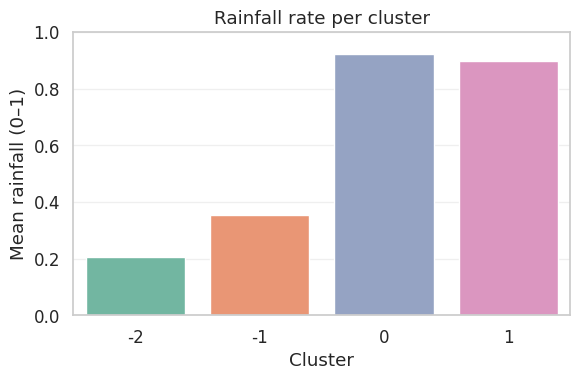

In [19]:
# Ensure cluster_agglo and rainfall are in your df
df_clustered = df_eda.copy()

# Rainfall rate per cluster
plt.figure(figsize=(6, 4))
rain_perc = df_clustered.groupby("cluster_agglo")[target_column].mean()
sns.barplot(x=rain_perc.index, y=rain_perc.values, palette="Set2")
plt.title("Rainfall rate per cluster")
plt.ylabel("Mean rainfall (0–1)")
plt.xlabel("Cluster")
plt.ylim(0, 1)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### 🌧️ Rainfall Distribution per Cluster

- **Cluster 0** and **Cluster 1** show the highest rainfall rates (≈90%), confirming their alignment with **rainy conditions**.
- **Cluster -2** corresponds to mostly **dry days** (~20%), while **Cluster -1** sits between both extremes (~35%).
- This reinforces that the **unsupervised clusters** map well to **rainfall behavior**, suggesting that meteorological patterns alone can separate rainy from non-rainy days.


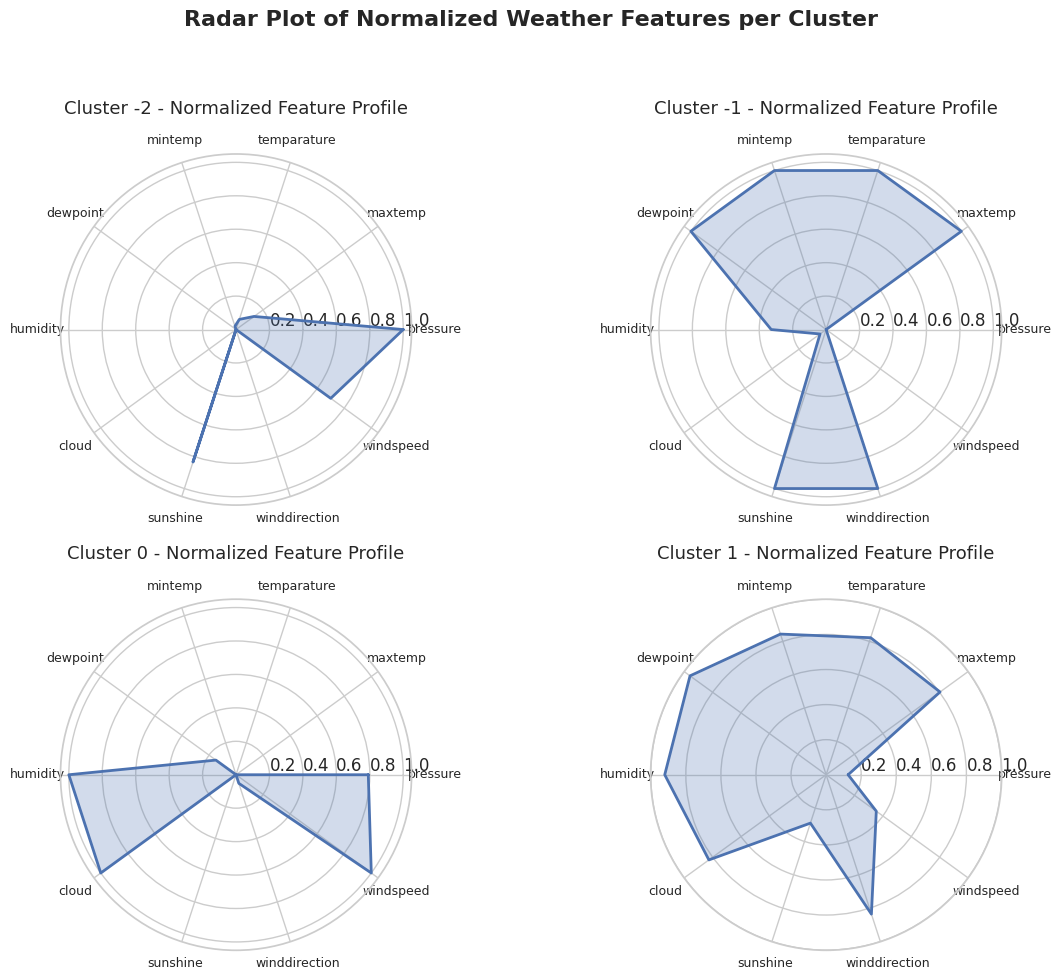

In [20]:
# Sort clusters for consistency
df_clustered["cluster_agglo"] = df_clustered["cluster_agglo"].astype(int)

# Cluster-wise means for each feature (raw values)
mean_df = df_clustered.groupby("cluster_agglo")[cols_to_use].mean().T  # shape = (features, clusters)

# Apply MinMaxScaler row-wise (each feature independently)
scaler = MinMaxScaler()
normalized = pd.DataFrame(
    scaler.fit_transform(mean_df.values.T).T,  # transpose twice to scale rows
    index=mean_df.index,
    columns=mean_df.columns
)
# 1. Radar chart setup
labels = normalized.index.tolist()
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the circle

# 2. Create 2x2 grid for clusters
fig, axs = plt.subplots(2, 2, subplot_kw=dict(polar=True), figsize=(12, 10))
axs = axs.flatten()  # Flatten to loop easily

for i, cluster in enumerate(normalized.columns):
    values = normalized[cluster].tolist()
    values += values[:1]  # close the shape

    ax = axs[i]
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_title(f"Cluster {cluster} - Normalized Feature Profile", fontsize=13, pad=15)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=9)
    ax.set_rlabel_position(0)
    ax.grid(True)

# Layout
plt.suptitle("Radar Plot of Normalized Weather Features per Cluster", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

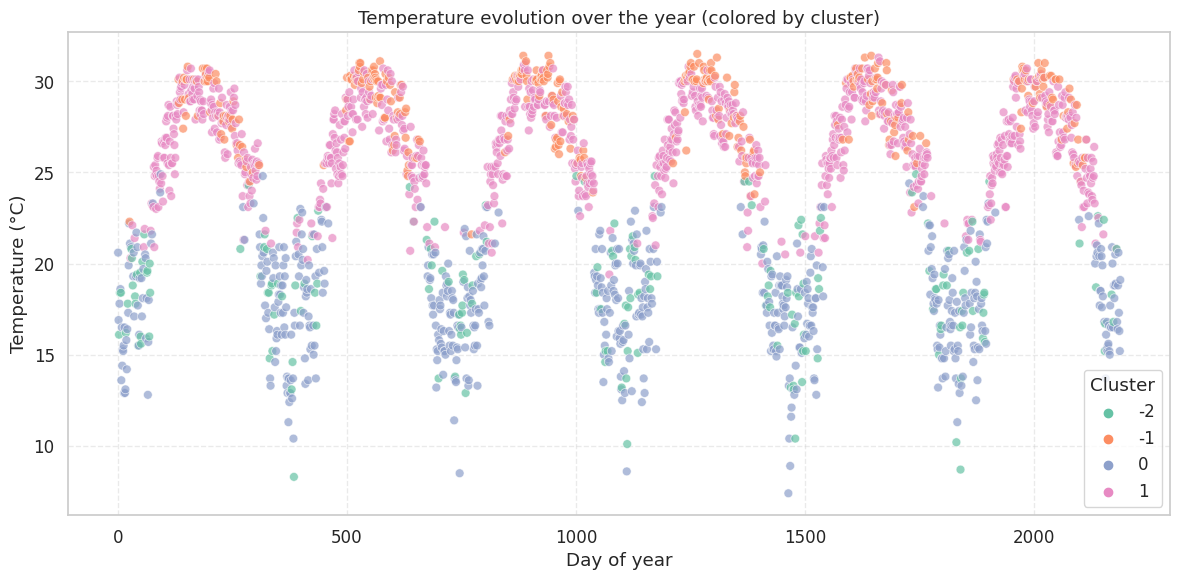

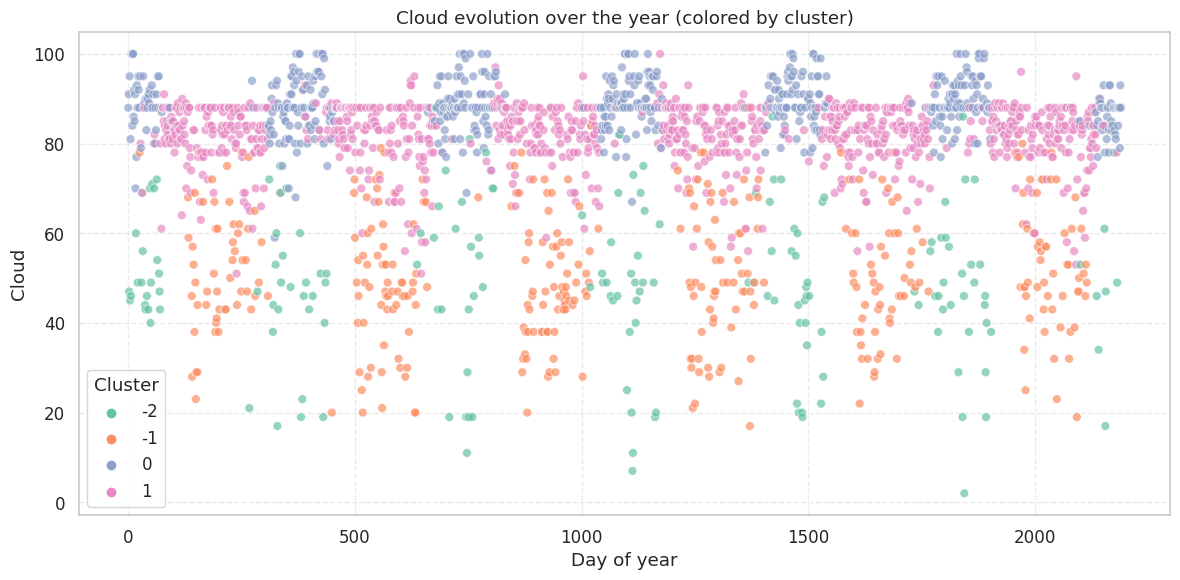

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Base DataFrame
df_plot = df_clustered.copy()

# Plot: temperature vs day of year
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_plot,
                x="id",
                y="temparature",
                hue="cluster_agglo",
                palette="Set2",
                alpha=0.7,
                s=40)

plt.title("Temperature evolution over the year (colored by cluster)")
plt.xlabel("Day of year")
plt.ylabel("Temperature (°C)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


# Plot: humidity vs day of year
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_plot,
                x="id",
                y="cloud",
                hue="cluster_agglo",
                palette="Set2",
                alpha=0.7,
                s=40)

plt.title("Cloud evolution over the year (colored by cluster)")
plt.xlabel("Day of year")
plt.ylabel("Cloud")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


### 🧠 Weather Cluster Profiling — Final Analysis

Based on PCA + Agglomerative Clustering (`k=4`) and a complete exploratory analysis, we identify **4 robust weather regimes**, each with distinct seasonal patterns and rainfall probabilities.

---

### ☀️ Cluster -2 — High Pressure & Windy Days

- **Pressure:** Extremely high ✅
- **Windspeed:** Strong  
- **Sunshine:** Abundant  
- **Humidity & Cloud:** Low  
- **Temperature:** Mild  
- **Rainfall rate:** ~20% ✅  
- **Seasonal profile:** Present in **early spring** and **late autumn**

🧭 **Interpretation:**  
Represents dry, anticyclonic conditions — clear skies, stable atmosphere. Winds are strong, but precipitation is unlikely. Seen in **shoulder seasons** where the weather is stable but not hot.

---

### 🔥 Cluster -1 — Hot & Sunny Summer Days

- **Temperature (all):** Highest among all clusters  
- **Sunshine:** Maximum possible  
- **Humidity & Cloud:** Low  
- **Rainfall rate:** ~35%  
- **Seasonal profile:** Peaks in **summer months**

🧭 **Interpretation:**  
A classic **dry summer regime**, often linked to heatwaves or continental hot spells. Air is dry, sky is clear, and cloud cover is minimal. Rainfall is not dominant but can occur in isolated storm events.

---

### 🌧️ Cluster 0 — Cool, Rainy & Cloudy

- **Cloud:** Maxed out (80–100%) ✅  
- **Humidity:** Very high  
- **Windspeed:** High  
- **Sunshine:** Nearly absent  
- **Temperature:** Cool  
- **Rainfall rate:** ~92% ✅  
- **Seasonal profile:** Throughout the year, especially in **cooler periods**

🧭 **Interpretation:**  
This is the **main rainy regime**. Saturated air, persistent cloudiness, and active wind systems. Likely linked to low-pressure zones. Its seasonal pattern confirms its dominance in **non-summer months**.

---

### 🌫️ Cluster 1 — Warm & Humid with Cloud Layer

- **Humidity & Cloud:** High  
- **Temperature & Dewpoint:** Elevated  
- **Sunshine:** Present but reduced  
- **Rainfall rate:** ~90%  
- **Seasonal profile:** Peaks in **early autumn** and occasionally in warm, stormy transitions

🧭 **Interpretation:**  
Represents a **humid regime**, with high dewpoint and frequent cloud cover. It bridges between warm air masses and moisture-rich instability. Seen in **late summer / early autumn** with potential for thunderstorms.

---

### 📊 Cross-Validation with Raw Distributions

- ✅ The **temperature vs. day** plot confirms clear seasonal behavior of clusters.
- ✅ The **cloud vs. day** distribution highlights that **Clusters 0 & 1** dominate at **high cloud levels**, while **Clusters -1 & -2** are tied to clear skies.
- ✅ Rainfall is cleanly stratified by cluster (`AUC ≈ 0.89`), validating the clustering quality.

---

## 🔍 Outlier Inspection

Before moving forward, it's important to assess the presence of potential outliers in the dataset. Outliers can distort the distribution of variables, affect PCA directions, and bias model training. We'll inspect the numerical features visually and statistically to detect anomalies or extreme values that may need attention.


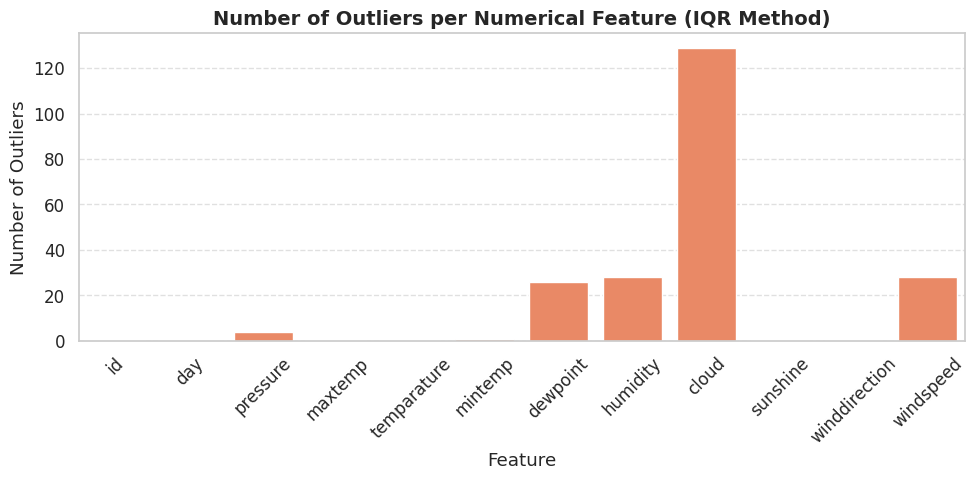

In [22]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Count outliers for each numerical feature
outlier_counts = {var: len(detect_outliers_iqr(train_df, var)) for var in numerical_columns}

# Create barplot
plt.figure(figsize=(10, 5))
sns.barplot(x=list(outlier_counts.keys()), y=list(outlier_counts.values()), color='coral')
plt.xticks(rotation=45)
plt.title("Number of Outliers per Numerical Feature (IQR Method)", fontsize=14, weight='bold')
plt.ylabel("Number of Outliers")
plt.xlabel("Feature")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 📉 Outlier Analysis (IQR Method)

- Most features show little to no outliers, except for `'cloud'`, which stands out with over **125 outlier values**.
- `'dewpoint'`, `'humidity'`, and `'windspeed'` also exhibit moderate levels of outliers.
- This suggests a potential need for **outlier handling or robust scaling** for those specific features prior to modeling.

In [23]:
# Estimate an automatic contamination level using percentiles
estimated_contamination = np.mean([
    len(detect_outliers_iqr(train_df, col)) / len(train_df) for col in numerical_columns
])

print(f"Estimated Contamination Rate: {estimated_contamination:.4f}")

Estimated Contamination Rate: 0.0082


### 🧪 Estimated Contamination Rate

Based on the average proportion of IQR outliers across all numerical features, the **estimated contamination rate** is approximately **0.82%**.  
This low rate suggests the dataset is relatively clean, and can guide the **contamination parameter** in anomaly detection models like Isolation Forest or LOF.

In [24]:
# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
train_df["anomaly"] = iso_forest.fit_predict(train_df[numerical_columns])

# Step 1: Detect IQR-based outliers across all numerical features
iqr_outliers = set()
for var in numerical_columns:
    iqr_outliers.update(detect_outliers_iqr(train_df, var).index)

# Step 2: Detect Isolation Forest anomalies
train_df["anomaly"] = iso_forest.fit_predict(train_df[numerical_columns])

# Step 3: Compare IQR outliers and Isolation Forest anomalies
iso_outliers = set(train_df[train_df["anomaly"] == -1].index)

# Step 4: Find common and unique outliers
common_outliers = iqr_outliers.intersection(iso_outliers)
only_iqr_outliers = iqr_outliers - iso_outliers
only_iso_outliers = iso_outliers - iqr_outliers

# Step 5: Print results
print(f"Total IQR Outliers: {len(iqr_outliers)}")
print(f"Total Isolation Forest Outliers: {len(iso_outliers)}")
print(f"Common Outliers: {len(common_outliers)}")
print(f"Outliers detected only by IQR: {len(only_iqr_outliers)}")
print(f"Outliers detected only by Isolation Forest: {len(only_iso_outliers)}")

Total IQR Outliers: 194
Total Isolation Forest Outliers: 110
Common Outliers: 72
Outliers detected only by IQR: 122
Outliers detected only by Isolation Forest: 38


## 🧭 Outlier Detection Comparison (IQR vs Isolation Forest)

To better understand the dataset's anomalies, we compared two detection strategies:

- **IQR Method**: flagged **194** data points as outliers.
- **Isolation Forest** (with contamination set to **5%**): detected **110** anomalies.

🔍 **Overlap Analysis**:
- **72 points** are commonly identified by both methods.
- **122 outliers** are unique to IQR → likely univariate deviations.
- **38 anomalies** are unique to Isolation Forest → potentially **multivariate** or **contextual** anomalies.

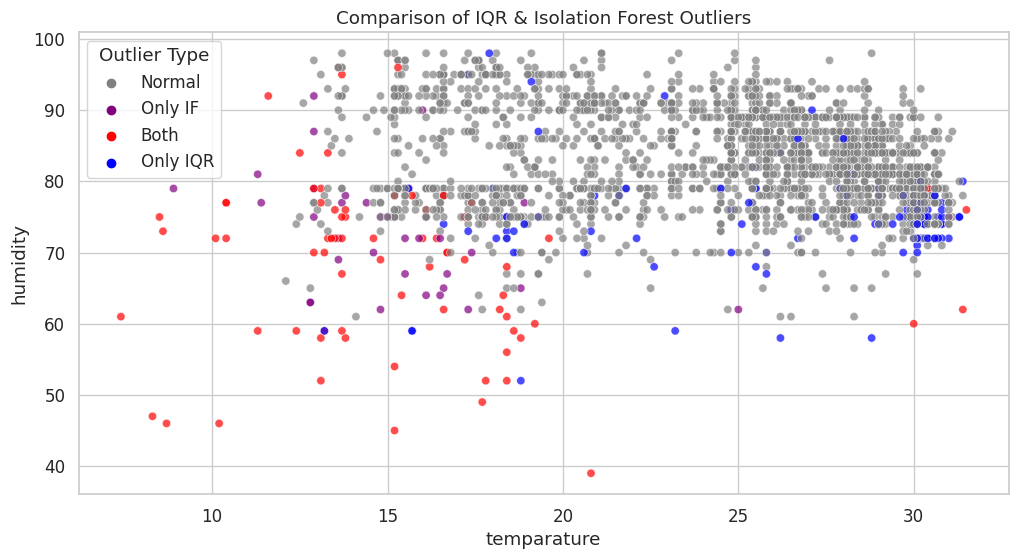

In [25]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=train_df["temparature"], y=train_df["humidity"], 
    hue=train_df.index.map(lambda idx: 
        "Both" if idx in common_outliers else 
        "Only IQR" if idx in only_iqr_outliers else 
        "Only IF" if idx in only_iso_outliers else "Normal"),
    palette={"Both": "red", "Only IQR": "blue", "Only IF": "purple", "Normal": "gray"},
    alpha=0.7
)
plt.title("Comparison of IQR & Isolation Forest Outliers")
plt.legend(title="Outlier Type")
plt.show()

- The plot contrasts **outlier detection methods** (IQR vs Isolation Forest) in the `temperature` vs `humidity` space.
- Most data points (gray) are classified as **normal** by both methods.
- **Red points** (common outliers) reveal a strong overlap between methods, mostly in low-temperature or low-humidity zones.
- **Blue points** are uniquely detected by IQR, especially at **extreme humidity** ends.
- **Purple points** (only Isolation Forest) are often found in **sparser regions**, confirming its strength at identifying more subtle multivariate anomalies.

➡️ **Conclusion**: Both methods are complementary — IQR captures statistical extremes, while Isolation Forest picks up more nuanced, multivariate deviations.

---

## ☔ Rainfall & Anomalies: Are Outliers More Likely to Rain?

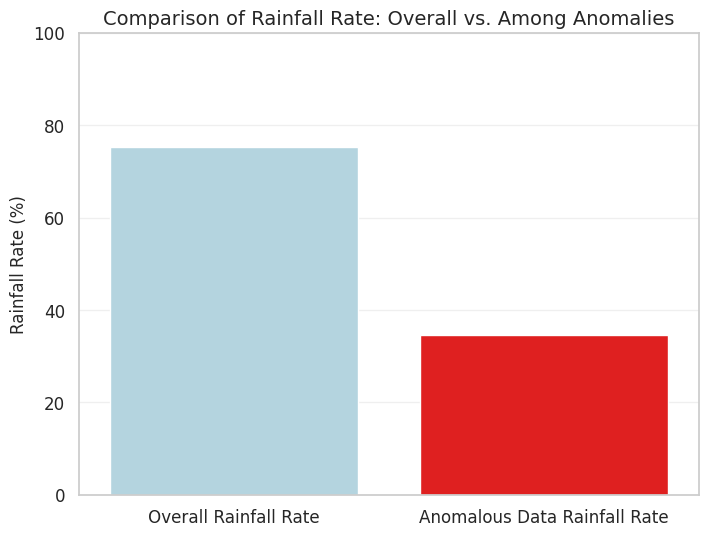

In [26]:
# Compute overall rainfall rate
global_rainfall_rate = train_df["rainfall"].mean() * 100  # Convert to percentage

# Compute rainfall rate among anomalies
anomaly_rainfall_rate = train_df[train_df["anomaly"] == -1]["rainfall"].mean() * 100  # Convert to percentage

# Create a DataFrame for visualization
rainfall_comparison = pd.DataFrame({
    "Category": ["Overall Rainfall Rate", "Anomalous Data Rainfall Rate"],
    "Rainfall Rate (%)": [global_rainfall_rate, anomaly_rainfall_rate]
})

# Plot the comparison
plt.figure(figsize=(8, 6))
sns.barplot(data=rainfall_comparison, x="Category", y="Rainfall Rate (%)", palette=["lightblue", "red"])


# Formatting
plt.title("Comparison of Rainfall Rate: Overall vs. Among Anomalies", fontsize=14)
plt.ylabel("Rainfall Rate (%)", fontsize=12)
plt.xlabel("")
plt.ylim(0, 100)  # Ensure the scale is percentage-based
plt.grid(axis="y", alpha=0.3)

# Show plot
plt.show()

We observe that:

- The **overall rainfall rate** is around **75%**.
- Among the **anomalous data points**, the rainfall rate drops to **~35%**.

➡️ **Conclusion**: Outliers are **less likely** to be rainy days. This suggests that anomalies may capture **unusual dry conditions** or edge weather patterns not representative of typical rainfall behavior.

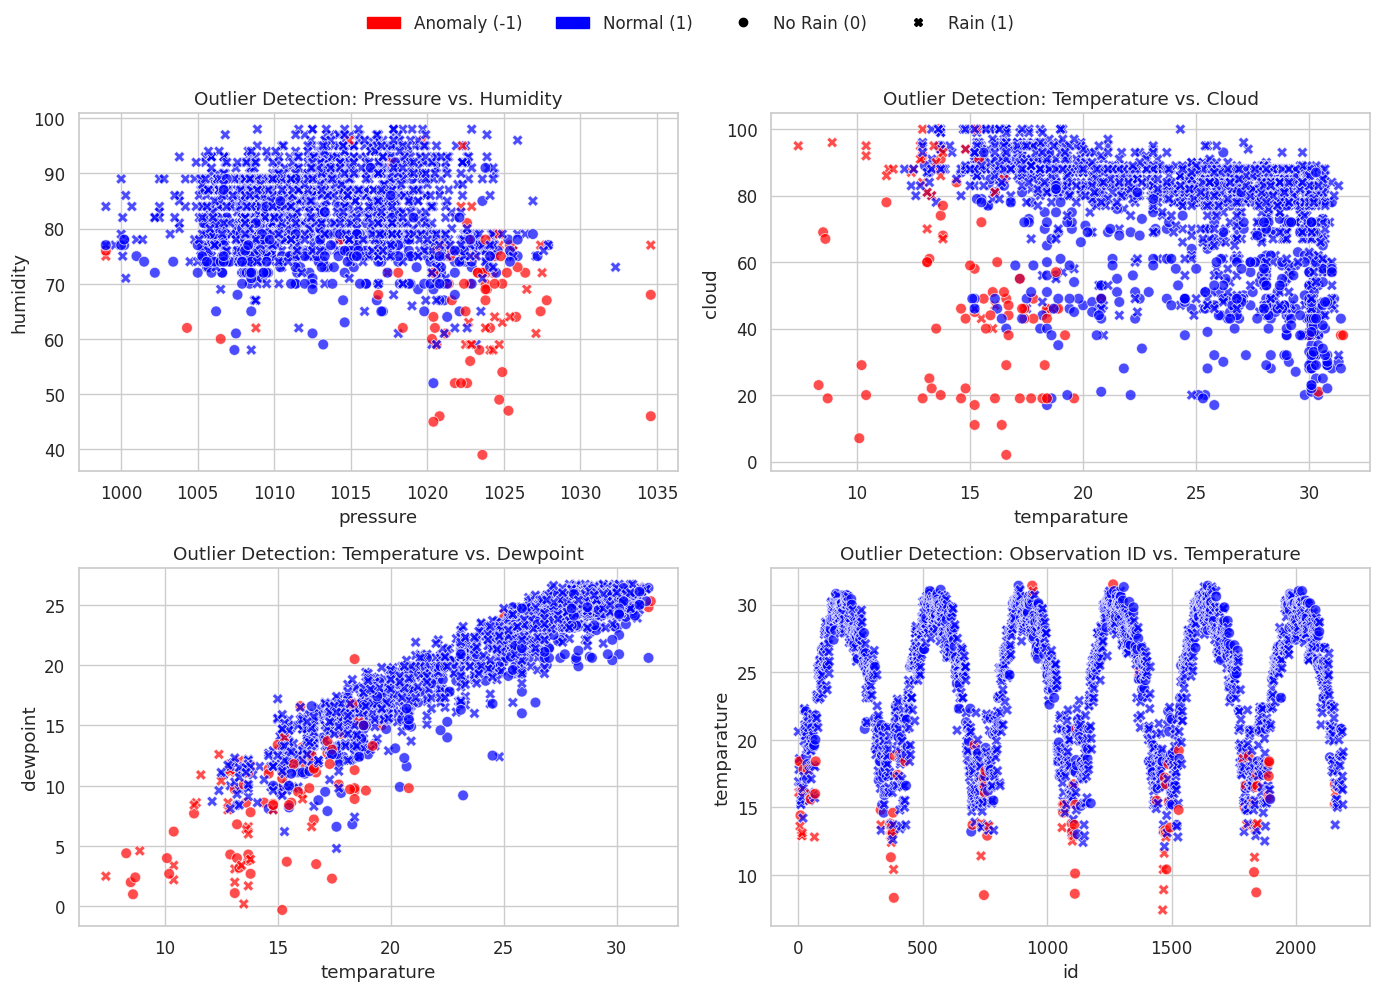

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Shared scatterplot parameters
scatter_kwargs = dict(
    palette={1: "blue", -1: "red"},
    s=60,
    alpha=0.7,
    legend=False
)

# Plot 1: Pressure vs. Humidity
sns.scatterplot(
    ax=axes[0, 0],
    x=train_df["pressure"], 
    y=train_df["humidity"], 
    hue=train_df["anomaly"], 
    style=train_df["rainfall"],
    **scatter_kwargs
)
axes[0, 0].set_title("Outlier Detection: Pressure vs. Humidity")

# Plot 2: Temperature vs. Cloud
sns.scatterplot(
    ax=axes[0, 1],
    x=train_df["temparature"], 
    y=train_df["cloud"], 
    hue=train_df["anomaly"], 
    style=train_df["rainfall"],
    **scatter_kwargs
)
axes[0, 1].set_title("Outlier Detection: Temperature vs. Cloud")

# Plot 3: Temperature vs. Dewpoint
sns.scatterplot(
    ax=axes[1, 0],
    x=train_df["temparature"], 
    y=train_df["dewpoint"], 
    hue=train_df["anomaly"], 
    style=train_df["rainfall"],
    **scatter_kwargs
)
axes[1, 0].set_title("Outlier Detection: Temperature vs. Dewpoint")

# Plot 4: ID vs. Temperature
sns.scatterplot(
    ax=axes[1, 1],
    x=train_df["id"], 
    y=train_df["temparature"], 
    hue=train_df["anomaly"], 
    style=train_df["rainfall"],
    **scatter_kwargs
)
axes[1, 1].set_title("Outlier Detection: Observation ID vs. Temperature")

# Custom Legend
anomaly_legend = [
    mpatches.Patch(color='red', label='Anomaly (-1)'),
    mpatches.Patch(color='blue', label='Normal (1)')
]

rainfall_legend = [
    mlines.Line2D([], [], color='black', marker='o', linestyle='None', label='No Rain (0)'),
    mlines.Line2D([], [], color='black', marker='X', linestyle='None', label='Rain (1)')
]

custom_legend = anomaly_legend + rainfall_legend
fig.legend(handles=custom_legend, loc='upper center', ncol=4, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

## 🔎 What the Scatterplots Reveal About Anomalies

- In all scatterplots, **red markers** represent anomalies detected by the Isolation Forest, and **blue markers** represent normal points.
- **Anomalies are not random** — they consistently appear in specific regions of feature space across all plots.
- In **Pressure vs. Humidity**, anomalies are mostly found in **low-pressure, high-humidity** zones — typical of unstable weather patterns or stormy conditions.
- In **Temperature vs. Cloud**, anomalies cluster around **low temperatures with high cloud coverage**, again hinting at poor weather or edge-case atmospheric conditions.
- The **Temperature vs. Dewpoint** plot shows that anomalies deviate from the main correlation line, suggesting either **measurement inconsistencies** or **physically rare scenarios**.
- The **ID vs. Temperature** plot shows that anomalies are **seasonally concentrated** (appearing during coldest periods of the year), suggesting **temporal patterns** in outlier behavior.

📌 **Conclusion**: Anomalies aren't noise — they often correspond to **extreme but valid weather conditions** (e.g., cold, rainy, or stormy days). Rather than being discarded blindly, these points may contain **meaningful information** about rare or impactful climate scenarios.

✅ This behavior aligns well with the previously estimated **contamination rate of 0.0082**, confirming that only a **very small, well-identified portion** of the dataset exhibits such rare patterns.

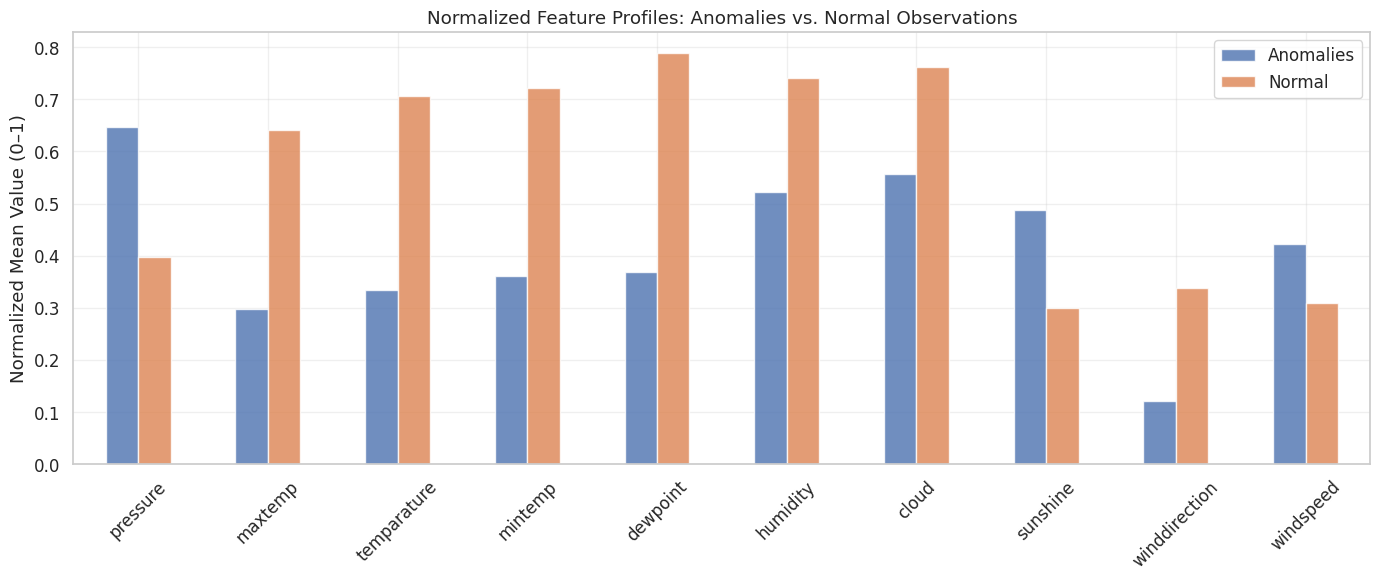

In [28]:
# Columns to include (exclude 'id' and 'day')
features = [col for col in numerical_columns if col not in ['id', 'day']]

# Normalize all selected features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(train_df[features])
df_scaled = pd.DataFrame(scaled, columns=features, index=train_df.index)

# Add anomaly column back for grouping
df_scaled["anomaly"] = train_df["anomaly"]

# Compute normalized mean profiles
anomaly_profile = df_scaled[df_scaled["anomaly"] == -1][features].mean()
normal_profile = df_scaled[df_scaled["anomaly"] == 1][features].mean()

# Build comparison DataFrame
comparison = pd.DataFrame({
    "Anomalies": anomaly_profile,
    "Normal": normal_profile
})

# Plot
comparison.plot(kind="bar", figsize=(14, 6), alpha=0.8)
plt.title("Normalized Feature Profiles: Anomalies vs. Normal Observations")
plt.ylabel("Normalized Mean Value (0–1)")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 📊 Anomaly vs. Normal Profile – Key Insights

This chart highlights the **mean weather conditions** (normalized between 0 and 1) for **anomalous vs. normal observations**.

### 🔍 Key Takeaways:

- **Anomalies** tend to occur with **lower values** of:
  - `temperature`
  - `humidity`
  - `dewpoint`
  - `cloud`

- **Sunshine** is **higher** on anomalous days, suggesting **clearer and drier weather** conditions.

- **Normal data** shows **higher values** for moisture-related features, consistent with **rainy or humid** conditions.

- **Pressure** is slightly higher during anomalies, possibly linked to **stable, dry atmospheric** conditions.

👉 These patterns confirm that **anomalies flagged by the model are not random** — they correspond to **specific, atypical but plausible weather regimes**.

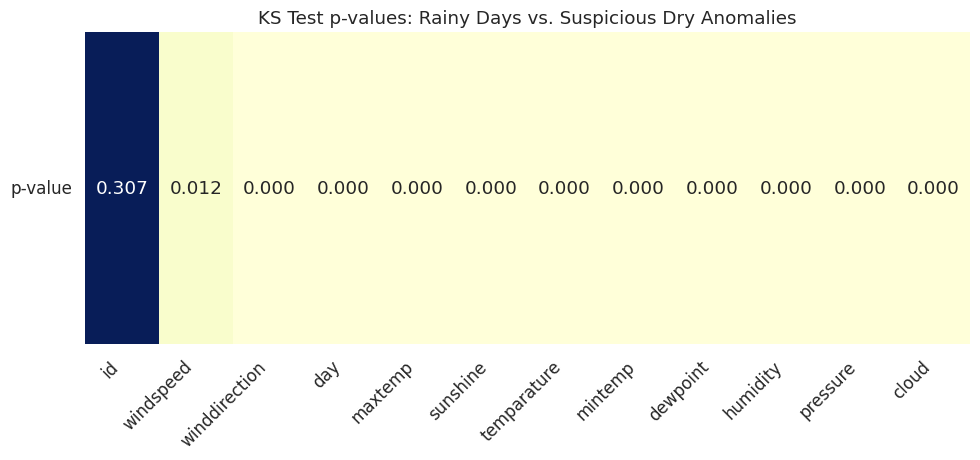

In [29]:
# Compare rainy days and suspicious dry anomalies
rainy_days = train_df[train_df["rainfall"] == 1]
suspicious_dry_days = train_df[(train_df["anomaly"] == -1) & (train_df["rainfall"] == 0)]

# Run KS-test for each numerical variable
ks_results = {}
for var in numerical_columns:
    stat, p_value = ks_2samp(rainy_days[var], suspicious_dry_days[var])
    ks_results[var] = {"KS Statistic": stat, "p-value": p_value}

# Create sorted DataFrame of results
ks_df = pd.DataFrame(ks_results).T.sort_values("p-value", ascending=False)

# Display as table
plt.figure(figsize=(10, len(ks_df)*0.4))
sns.heatmap(
    ks_df[["p-value"]].T,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",
    cbar=False
)
plt.title("KS Test p-values: Rainy Days vs. Suspicious Dry Anomalies")
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 🔬 Statistical Comparison: Rainy Days vs. Dry Anomalies

We performed a two-sample **Kolmogorov-Smirnov test** to compare each weather variable between:
- 🌧️ **Rainy days** (`rainfall = 1`)
- 🔴 **Anomalies without rain** (`anomaly = -1` & `rainfall = 0`)

### ✅ Key Insights

- **Only `id` showed no significant difference** (p = 0.31), which is expected since it's not meteorological.
- All **weather-related features** (e.g., temperature, pressure, humidity, dew point) showed **very significant differences** (p ≪ 0.05).
- The most different variables were:
  - `cloud`, `pressure`, `humidity`, `dewpoint`, `mintemp`, `temperature`, `sunshine`
- These results suggest that **dry anomalies do not statistically resemble rainy days** across most meteorological dimensions.

### ⚠️ Conclusion

Although the **intuition was good**, the statistical evidence shows that the **dry anomalies behave very differently** from typical rainy days. They are **not "missed rain events"**, but rather **outliers due to other rare conditions**.




## 📊 Overall EDA Conclusion

The exploratory data analysis (EDA) provides several key insights into the dataset and the nature of the anomalies:

- **Balanced Data Structure**: The dataset contains 2,190 entries with no missing values, covering a full year of daily weather data.
- **Feature Distributions**:
  - Most weather features (e.g., `temperature`, `humidity`, `dewpoint`) show clear seasonal trends and non-Gaussian distributions.
  - Some variables, such as `cloud` and `sunshine`, are notably skewed and may require transformation for modeling.
- **PCA Insights**:
  - PCA reveals strong seasonal patterns in the weather conditions.
  - Rainfall days form a distinguishable cloud in PCA space, indicating that weather patterns differ systematically between rainy and non-rainy days.
- **Outlier Detection**:
  - Outliers detected via IQR and Isolation Forest are consistent with rare but plausible meteorological conditions (e.g., cold and dry weather).
  - A contamination rate of ~0.0082 suggests only a small portion of the data is anomalous — validating the model's robustness.
- **Anomalies vs. Rainfall**:
  - Anomalies are **not randomly distributed**; they are associated with atypical weather regimes.
  - KS tests confirm that anomalous dry days differ **statistically** from rainy days across nearly all weather variables.

🔍 **Conclusion**: The dataset is clean, rich in seasonal structure, and suitable for both supervised and unsupervised learning. Outliers contain meaningful information and should be analyzed, not discarded. These insights will guide robust modeling and interpretation of rainfall events.

In [30]:
fe_df = train_df.copy()

In [31]:
from sklearn.feature_selection import f_classif
import pandas as pd

# Données
X = fe_df[numerical_columns]  # ou ajoute tes features manuelles si besoin
y = fe_df["rainfall"]

# Test ANOVA F
f_values, p_values = f_classif(X, y)

# Résumé dans un DataFrame
anova_df = pd.DataFrame({
    "feature": X.columns,
    "f_value": f_values,
    "p_value": p_values
}).sort_values(by="f_value", ascending=False)

# Affichage
print(anova_df)


          feature      f_value        p_value
8           cloud  1527.566646  6.744508e-254
9        sunshine   975.420284  2.123381e-177
7        humidity   568.743429  6.194524e-112
11      windspeed    27.606568   1.630871e-07
6        dewpoint    14.798992   1.230212e-04
3         maxtemp    13.847526   2.032564e-04
2        pressure     5.458570   1.956243e-02
4     temparature     5.409243   2.012137e-02
0              id     2.483885   1.151624e-01
5         mintemp     1.577513   2.092534e-01
10  winddirection     0.105360   7.455205e-01
1             day     0.000467   9.827626e-01


## 🔍 ANOVA F-Test Analysis: Variable Selection for Rainfall Prediction

### ✅ Most Discriminative Features
These variables show extremely strong statistical significance with respect to the binary target (`rainfall`). Their `f_value` and `p_value` indicate high separability between rain/no-rain cases:

| Feature     | F-value     | P-value        | Interpretation |
|-------------|-------------|----------------|----------------|
| `cloud`     | 1527.57     | ~0             | Extremely strong predictor of rainfall. |
| `sunshine`  | 975.42      | ~0             | Strong negative correlation with rain. |
| `humidity`  | 568.74      | ~0             | High humidity increases likelihood of rain. |

These should be **definitely included** in your logistic regression model.

---

### 🟡 Moderately Informative Features

| Feature       | F-value | P-value | Interpretation |
|---------------|---------|---------|----------------|
| `windspeed`   | 27.61   | 1.6e-07 | May capture wind bursts before rain events. |
| `dewpoint`    | 14.80   | 0.0001  | Indicates moisture level, somewhat informative. |
| `maxtemp`     | 13.85   | 0.0002  | Could reflect instability in temperature. |
| `pressure`    | 5.46    | 0.02    | Weak but potentially relevant. |
| `temparature` | 5.49    | 0.02    | May be redundant with other features. |

These are **worth testing**, especially in combination with each other.

---

### 🔴 Features with Low or No Discriminative Power

| Feature         | F-value | P-value | Recommendation |
|-----------------|---------|---------|----------------|
| `id`            | 2.48    | 0.11    | Should be dropped (just an index). |
| `mintemp`       | 1.58    | 0.21    | Not useful on its own. Consider using `difftemp` instead. |
| `winddirection` | 0.10    | 0.75    | Useless in raw form, could be transformed (e.g., RBF). |
| `day`           | 0.0005  | 0.99    | Completely non-informative. |




In [32]:
# Cyclical encoding of day
fe_df["day_sin"] = np.sin(2 * np.pi * fe_df["day"] / 365)
fe_df["day_cos"] = np.cos(2 * np.pi * fe_df["day"] / 365)
fe_df['TempDiff'] = train_df['maxtemp'] - train_df['mintemp']

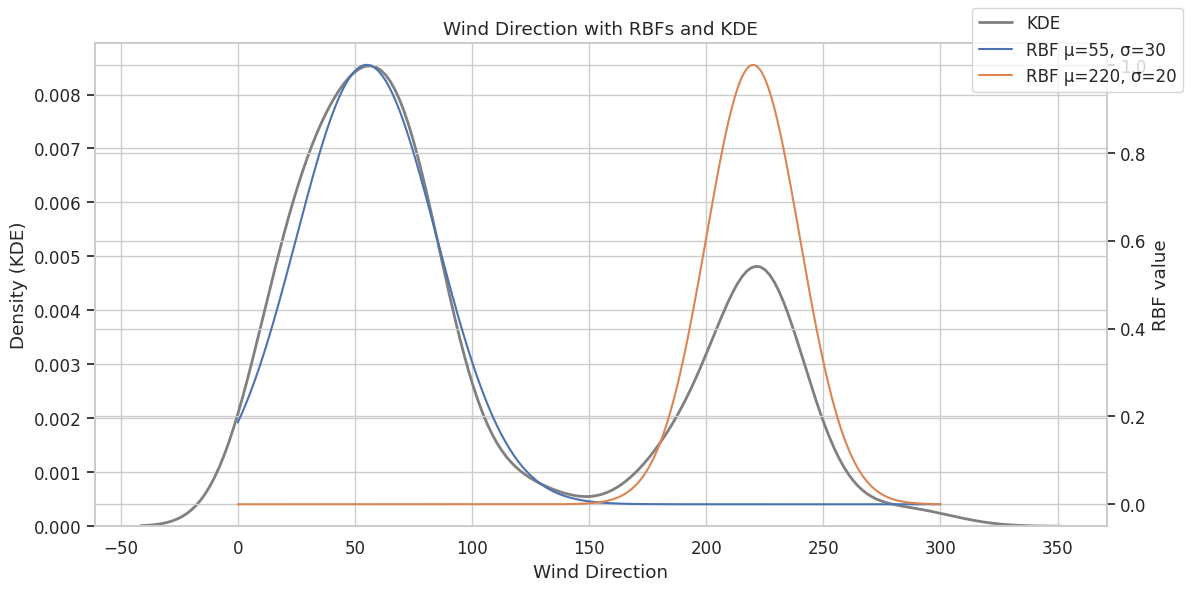

In [33]:
# Paramètres finaux
mu_list = [55, 220]
sigma_list = [30, 20]
x = np.linspace(0, 300, 500)

# Figure avec deux axes Y
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# KDE seule (pas d'histogramme)
sns.kdeplot(train_df['winddirection'], ax=ax1, color='gray', linewidth=2, label='KDE')

# RBF superposées avec correspondance mu ↔ sigma
for mu, sigma in zip(mu_list, sigma_list):
    rbf = np.exp(- (x - mu)**2 / (2 * sigma**2))
    ax2.plot(x, rbf, label=f'RBF μ={mu}, σ={sigma}')

# Mise en forme
ax1.set_xlabel('Wind Direction')
ax1.set_ylabel('Density (KDE)')
ax2.set_ylabel('RBF value')
plt.title('Wind Direction with RBFs and KDE')
fig.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
# Paramètres
mu_list = [55, 220]
sigma_list = [30, 20]

# Application RBF et ajout des colonnes au DataFrame
for mu, sigma in zip(mu_list, sigma_list):
    col_name = f'rbf_{mu}_{sigma}'
    fe_df[col_name] = np.exp(- (fe_df['winddirection'] - mu)**2 / (2 * sigma**2))

In [35]:
# Base: start from original numerical columns
columns_to_use = [col for col in numerical_columns if col not in ['id', 'day', 'maxtemp', 'mintemp', 'winddirection']]

# Add new engineered features
columns_to_use += ['day_sin', 'day_cos', 'TempDiff']

# Add all RBF features automatically
rbf_features = [col for col in fe_df.columns if col.startswith('rbf_')]
columns_to_use += rbf_features

# Final list
print("✅ Final columns used for modeling:")
print(columns_to_use)


✅ Final columns used for modeling:
['pressure', 'temparature', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed', 'day_sin', 'day_cos', 'TempDiff', 'rbf_55_30', 'rbf_220_20']


In [36]:
# Prepare training data
X = fe_df[columns_to_use]  # ou ajoute tes features manuelles si besoin
y = fe_df[target_column]

# Test ANOVA F
f_values, p_values = f_classif(X, y)

# Résumé dans un DataFrame
anova_df = pd.DataFrame({
    "feature": X.columns,
    "f_value": f_values,
    "p_value": p_values
}).sort_values(by="f_value", ascending=False)

# Affichage
print(anova_df)


        feature      f_value        p_value
4         cloud  1527.566646  6.744508e-254
5      sunshine   975.420284  2.123381e-177
3      humidity   568.743429  6.194524e-112
9      TempDiff    95.942311   3.357585e-22
6     windspeed    27.606568   1.630871e-07
2      dewpoint    14.798992   1.230212e-04
7       day_sin    12.379705   4.428815e-04
10    rbf_55_30     7.467635   6.332315e-03
0      pressure     5.458570   1.956243e-02
1   temparature     5.409243   2.012137e-02
8       day_cos     5.042485   2.483244e-02
11   rbf_220_20     0.718241   3.968142e-01


In [37]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Evaluate
accuracy = model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.8562



🎯 Meilleur taux de contamination trouvé :
Contamination = 0.00132, ROC AUC = 0.8939 ± 0.0197


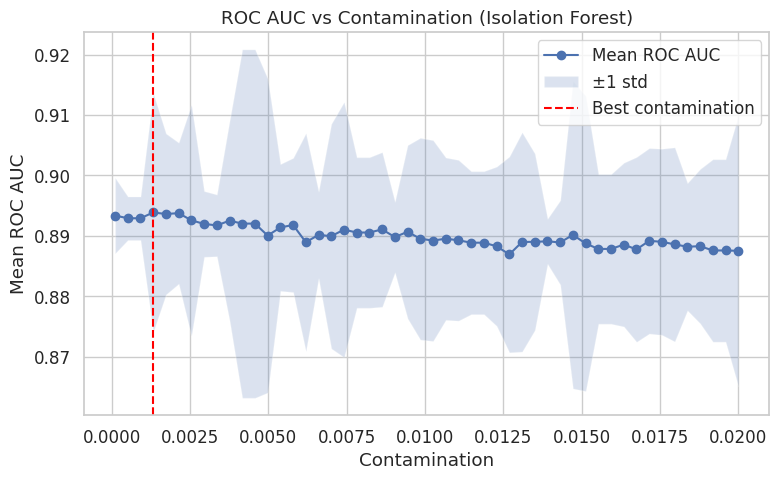

In [38]:
# Données
X = fe_df[columns_to_use].copy()
y = fe_df[target_column].copy()

# Paramètres
contamination_values = np.linspace(0.0001, 0.02, 50)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Résultats
results = []

for contamination in contamination_values:
    iso = IsolationForest(contamination=contamination, random_state=42)
    iso.fit(X)
    mask_inliers = iso.predict(X) == 1
    X_clean = X[mask_inliers]
    y_clean = y[mask_inliers]

    fold_aucs = []

    for train_idx, test_idx in cv.split(X_clean, y_clean):
        X_train, X_test = X_clean.iloc[train_idx], X_clean.iloc[test_idx]
        y_train, y_test = y_clean.iloc[train_idx], y_clean.iloc[test_idx]

        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(random_state = 42))
        ])

        pipe.fit(X_train, y_train)
        y_pred_proba = pipe.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        fold_aucs.append(auc)

    mean_auc = np.mean(fold_aucs)
    std_auc = np.std(fold_aucs)
    results.append((contamination, mean_auc, std_auc))

# Résultats sous forme de DataFrame
results_df = pd.DataFrame(results, columns=["contamination", "mean_auc", "std_auc"])
best_row = results_df.loc[results_df["mean_auc"].idxmax()]

# Affichage meilleur résultat
print("\n🎯 Meilleur taux de contamination trouvé :")
print(f"Contamination = {best_row['contamination']:.5f}, ROC AUC = {best_row['mean_auc']:.4f} ± {best_row['std_auc']:.4f}")

# Tracé
plt.figure(figsize=(8, 5))
plt.plot(results_df["contamination"], results_df["mean_auc"], label="Mean ROC AUC", marker="o")
plt.fill_between(results_df["contamination"],
                 results_df["mean_auc"] - results_df["std_auc"],
                 results_df["mean_auc"] + results_df["std_auc"],
                 alpha=0.2, label="±1 std")
plt.axvline(best_row["contamination"], color="red", linestyle="--", label="Best contamination")
plt.title("ROC AUC vs Contamination (Isolation Forest)")
plt.xlabel("Contamination")
plt.ylabel("Mean ROC AUC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
# Retrieve the optimal contamination value
best_c = best_row['contamination']

# Run Isolation Forest with optimal contamination
iso = IsolationForest(contamination=best_c, random_state=42)
iso.fit(X)
mask_inliers = iso.predict(X) == 1  # Keep only inliers (label 1)

# Filter X and y
X_final = X[mask_inliers].copy()
y_final = y[mask_inliers].copy()

# Optional: also filter fe_df if you want to reuse it later
fe_df_clean = fe_df.loc[mask_inliers].copy()

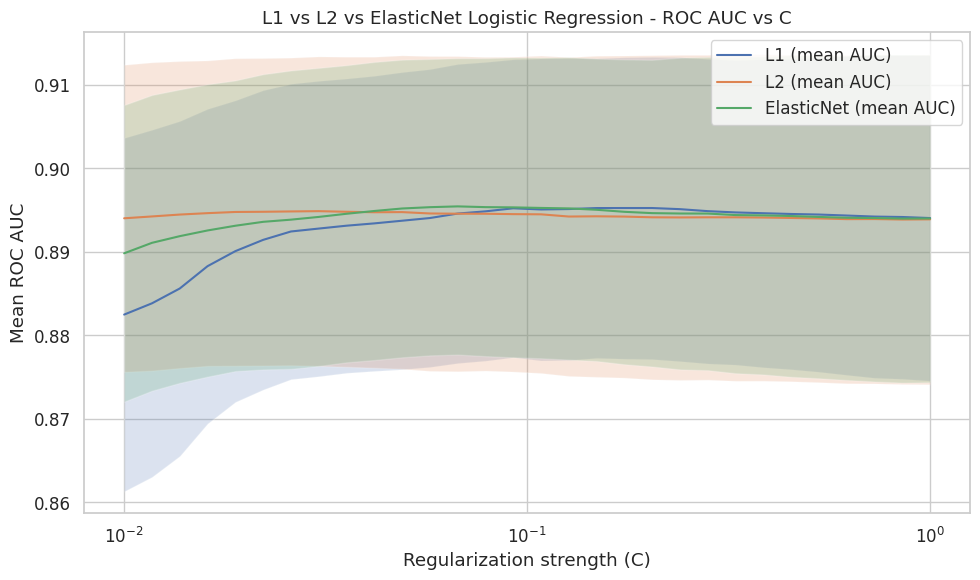

🔍 Best configuration per penalty:
L1: C = 0.1743, ROC AUC = 0.8952
L2: C = 0.0304, ROC AUC = 0.8949
ElasticNet: C = 0.0672, ROC AUC = 0.8954


In [40]:
# Data
X = fe_df_clean[columns_to_use].copy()
y = fe_df_clean[target_column].copy()

# Regularization values to test
C_values = np.logspace(-2, 0, 30)  # from 0.01 to 1.0

# Store results
results = {
    "L1": {"mean_auc": [], "std_auc": []},
    "L2": {"mean_auc": [], "std_auc": []},
    "ElasticNet": {"mean_auc": [], "std_auc": []}
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop over regularization types
for penalty in ["l1", "l2", "elasticnet"]:
    for C in C_values:
        fold_scores = []
        for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Solver + l1_ratio
            solver = 'saga'  # required for l1 and elasticnet
            l1_ratio = 0.5 if penalty == "elasticnet" else None

            model = LogisticRegression(
                penalty=penalty,
                solver=solver,
                l1_ratio=l1_ratio,
                C=C,
                max_iter=1000,
                random_state=42
            )

            # Pipeline
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('logit', model)
            ])

            pipe.fit(X_train, y_train)
            y_pred_proba = pipe.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_pred_proba)
            fold_scores.append(auc)

        # Store mean/std for this config
        key = "ElasticNet" if penalty == "elasticnet" else penalty.upper()
        results[key]["mean_auc"].append(np.mean(fold_scores))
        results[key]["std_auc"].append(np.std(fold_scores))

# 📈 Plot results
plt.figure(figsize=(10, 6))
for penalty in ["L1", "L2", "ElasticNet"]:
    mean_auc = results[penalty]["mean_auc"]
    std_auc = results[penalty]["std_auc"]
    plt.plot(C_values, mean_auc, label=f'{penalty} (mean AUC)')
    plt.fill_between(C_values,
                     np.array(mean_auc) - np.array(std_auc),
                     np.array(mean_auc) + np.array(std_auc),
                     alpha=0.2)

plt.xscale('log')
plt.xlabel('Regularization strength (C)')
plt.ylabel('Mean ROC AUC')
plt.title('L1 vs L2 vs ElasticNet Logistic Regression - ROC AUC vs C')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔍 Best config summary
best_config = {}
for penalty in ["L1", "L2", "ElasticNet"]:
    idx = np.argmax(results[penalty]["mean_auc"])
    best_config[penalty] = {
        "C": C_values[idx],
        "ROC AUC": results[penalty]["mean_auc"][idx]
    }

print("🔍 Best configuration per penalty:")
for penalty, info in best_config.items():
    print(f"{penalty}: C = {info['C']:.4f}, ROC AUC = {info['ROC AUC']:.4f}")

In [41]:
# Données réelles
X = fe_df_clean[columns_to_use].copy()
y = fe_df_clean[target_column].copy()

# Dictionnaire des modèles
models = {
    "Logistic Regression (L1)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=0.0672, max_iter=1000, random_state=42))
    ]),
    "Naive Bayes": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", GaussianNB())
    ]),
    "K-NN (k=5)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=5))
    ]),
    "SVM (RBF)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', C=1.0, probability=True))
    ]),
    "Bagging (DecisionTree)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", BaggingClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=3),
            n_estimators=50,
            random_state=42))
    ])
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

# Évaluation
for name, model in models.items():
    fold_scores = []
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        fold_scores.append(auc)

    results[name] = {
        "mean_auc": np.mean(fold_scores),
        "std_auc": np.std(fold_scores)
    }

# Résultats sous forme de tableau
results_df = pd.DataFrame(results).T.sort_values("mean_auc", ascending=False)
print("\n📊 Comparaison des modèles (ROC AUC):\n")
print(results_df.round(4))


📊 Comparaison des modèles (ROC AUC):

                          mean_auc  std_auc
Logistic Regression (L1)    0.8954   0.0177
Bagging (DecisionTree)      0.8848   0.0196
Naive Bayes                 0.8776   0.0201
SVM (RBF)                   0.8603   0.0333
K-NN (k=5)                  0.8316   0.0365


In [42]:
# 1. Configuration
X_base = fe_df_clean[columns_to_use].copy()
y_base = fe_df_clean[target_column].copy()
n_aug = 3  # nombre de copies bruitées par échantillon
noise_level = 0.01  # niveau de bruit (à adapter selon les unités)

# 2. Fonction d'augmentation
def jitter_augment(X, y, n_aug=3, noise_level=0.01):
    X_aug = pd.concat([X + np.random.normal(0, noise_level, X.shape) for _ in range(n_aug)], ignore_index=True)
    y_aug = pd.concat([y.copy() for _ in range(n_aug)], ignore_index=True)
    return pd.concat([X, X_aug], ignore_index=True), pd.concat([y, y_aug], ignore_index=True)

# 3. Génération des données augmentées
X_aug, y_aug = jitter_augment(X_base, y_base, n_aug=n_aug, noise_level=noise_level)

# 4. Cross-validation sur données augmentées
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_aucs = []

for train_idx, test_idx in cv.split(X_base, y_base):  # Évaluation uniquement sur données originales
    # On split X_base mais on entraîne sur X_aug complet
    X_train_aug = X_aug.iloc[train_idx.tolist() + [len(X_base) + i for i in range(len(train_idx) * n_aug)]]
    y_train_aug = y_aug.iloc[train_idx.tolist() + [len(y_base) + i for i in range(len(train_idx) * n_aug)]]

    X_test = X_base.iloc[test_idx]
    y_test = y_base.iloc[test_idx]

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=0.0672, max_iter=1000, random_state=42))
    ])

    pipe.fit(X_train_aug, y_train_aug)
    y_pred_proba = pipe.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    fold_aucs.append(auc)

# 5. Résultat final
print(f"\n📈 ROC AUC avec augmentation (jitter x{n_aug}, bruit={noise_level}):")
print(f"Mean ROC AUC = {np.mean(fold_aucs):.4f} ± {np.std(fold_aucs):.4f}")



📈 ROC AUC avec augmentation (jitter x3, bruit=0.01):
Mean ROC AUC = 0.8964 ± 0.0183


In [43]:
"""
# Data
X = fe_df_clean[columns_to_use].copy()
y = fe_df_clean[target_column].copy()

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Scaler
scaler = StandardScaler()

# Define RF hyperparameter search space (shallow trees + bagging style)
param_dist = {
    "clf__n_estimators": [50, 100, 200, 300, 500],
    "clf__max_depth": [3, 5, 7, 10],
    "clf__min_samples_split": [2, 4, 6],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ['sqrt', 'log2', 0.5],
    "clf__bootstrap": [True],  # classic bagging
    "clf__class_weight": ['balanced']  # small data benefit
}

# Pipeline: Standardization + RF
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=42))
])

# AUC scorer
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=50,
    scoring=auc_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit search
random_search.fit(X, y)

# Results
print("\n✅ Random Forest - Best AUC:", random_search.best_score_)
print("🏆 Random Forest - Best Params:", random_search.best_params_)

# Save best model
best_rf_model = random_search.best_estimator_
"""

'\n# Data\nX = fe_df_clean[columns_to_use].copy()\ny = fe_df_clean[target_column].copy()\n\n# Cross-validation\ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\n# Scaler\nscaler = StandardScaler()\n\n# Define RF hyperparameter search space (shallow trees + bagging style)\nparam_dist = {\n    "clf__n_estimators": [50, 100, 200, 300, 500],\n    "clf__max_depth": [3, 5, 7, 10],\n    "clf__min_samples_split": [2, 4, 6],\n    "clf__min_samples_leaf": [1, 2, 4],\n    "clf__max_features": [\'sqrt\', \'log2\', 0.5],\n    "clf__bootstrap": [True],  # classic bagging\n    "clf__class_weight": [\'balanced\']  # small data benefit\n}\n\n# Pipeline: Standardization + RF\npipe = Pipeline([\n    ("scaler", StandardScaler()),\n    ("clf", RandomForestClassifier(random_state=42))\n])\n\n# AUC scorer\nauc_scorer = make_scorer(roc_auc_score, needs_proba=True)\n\n# Randomized search\nrandom_search = RandomizedSearchCV(\n    estimator=pipe,\n    param_distributions=param_dist,\n    n_iter

In [44]:
"""
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
import numpy as np

# Data
X = fe_df_clean[columns_to_use].copy()
y = fe_df_clean[target_column].copy()

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# AUC scoring
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Slimmed param grid for small data
xgb_param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.1, 1, 10],
}

# Model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    verbosity=0
)

# Randomized Search
xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_dist,
    n_iter=50,  # less iterations for small data
    scoring=auc_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit
xgb_search.fit(X, y)

# Results
print("\n✅ XGBoost - Best AUC:", xgb_search.best_score_)
print("🏆 XGBoost - Best Params:", xgb_search.best_params_)

# Save best model
best_xgb = xgb_search.best_estimator_
"""

'\nfrom xgboost import XGBClassifier\nfrom sklearn.model_selection import RandomizedSearchCV, StratifiedKFold\nfrom sklearn.metrics import make_scorer, roc_auc_score\nimport numpy as np\n\n# Data\nX = fe_df_clean[columns_to_use].copy()\ny = fe_df_clean[target_column].copy()\n\n# Cross-validation\ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\n# AUC scoring\nauc_scorer = make_scorer(roc_auc_score, needs_proba=True)\n\n# Slimmed param grid for small data\nxgb_param_dist = {\n    \'n_estimators\': [100, 200, 300, 400],\n    \'learning_rate\': [0.01, 0.05, 0.1, 0.2],\n    \'max_depth\': [3, 4, 5, 6],\n    \'subsample\': [0.6, 0.8, 1.0],\n    \'colsample_bytree\': [0.6, 0.8, 1.0],\n    \'gamma\': [0, 1, 5],\n    \'reg_alpha\': [0, 0.01, 0.1],\n    \'reg_lambda\': [0.1, 1, 10],\n}\n\n# Model\nxgb_model = XGBClassifier(\n    use_label_encoder=False,\n    eval_metric=\'logloss\',\n    random_state=42,\n    verbosity=0\n)\n\n# Randomized Search\nxgb_search = RandomizedSearch

In [45]:
"""
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, roc_auc_score
import numpy as np

# Data
X = fe_df_clean[columns_to_use].copy()
y = fe_df_clean[target_column].copy()

# AUC scorer
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logit", LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga', random_state=42))
])

# Param distribution (all values inside lists or np arrays)
logreg_param_dist = {
    'logit__penalty': ['l1', 'l2', 'elasticnet'],
    'logit__C': np.logspace(-4, 4, 20),
    'logit__solver': ['saga'],
    'logit__l1_ratio': np.linspace(0, 1, 10)  # Only used for elasticnet, ignored otherwise
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search
logreg_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=logreg_param_dist,
    n_iter=100,
    scoring=auc_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the model
logreg_search.fit(X, y)

# Results
print("\n✅ Logistic Regression - Best AUC:", logreg_search.best_score_)
print("🏆 Logistic Regression - Best Params:", logreg_search.best_params_)

# Best model
best_logreg = logreg_search.best_estimator_
"""

'\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.model_selection import RandomizedSearchCV, StratifiedKFold\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.metrics import make_scorer, roc_auc_score\nimport numpy as np\n\n# Data\nX = fe_df_clean[columns_to_use].copy()\ny = fe_df_clean[target_column].copy()\n\n# AUC scorer\nauc_scorer = make_scorer(roc_auc_score, needs_proba=True)\n\n# Pipeline\npipe = Pipeline([\n    ("scaler", StandardScaler()),\n    ("logit", LogisticRegression(max_iter=1000, class_weight=\'balanced\', solver=\'saga\', random_state=42))\n])\n\n# Param distribution (all values inside lists or np arrays)\nlogreg_param_dist = {\n    \'logit__penalty\': [\'l1\', \'l2\', \'elasticnet\'],\n    \'logit__C\': np.logspace(-4, 4, 20),\n    \'logit__solver\': [\'saga\'],\n    \'logit__l1_ratio\': np.linspace(0, 1, 10)  # Only used for elasticnet, ignored otherwise\n}\n\n# Cross-validation\ncv = Stratified

In [46]:
"""
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score

# Data (CatBoost handles raw features well)
X = fe_df_clean[columns_to_use].copy()
y = fe_df_clean[target_column].copy()

# AUC Scorer
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# CatBoost model
catboost_model = CatBoostClassifier(
    verbose=0,
    random_state=42,
    eval_metric="AUC",
    task_type="CPU"  # adapt to "GPU" if available
)

# Parameter grid
catboost_param_dist = {
    'iterations': [100, 300, 500, 700],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0.0, 0.5, 1.0],
    'border_count': [32, 64, 128],
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Search
catboost_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=catboost_param_dist,
    n_iter=60,
    scoring=auc_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit
catboost_search.fit(X, y)

# Results
print("\n✅ CatBoost - Best AUC:", catboost_search.best_score_)
print("🏆 CatBoost - Best Params:", catboost_search.best_params_)

# Save best model
best_catboost = catboost_search.best_estimator_
"""

'\nfrom catboost import CatBoostClassifier\nfrom sklearn.model_selection import RandomizedSearchCV, StratifiedKFold\nfrom sklearn.metrics import make_scorer, roc_auc_score\n\n# Data (CatBoost handles raw features well)\nX = fe_df_clean[columns_to_use].copy()\ny = fe_df_clean[target_column].copy()\n\n# AUC Scorer\nauc_scorer = make_scorer(roc_auc_score, needs_proba=True)\n\n# CatBoost model\ncatboost_model = CatBoostClassifier(\n    verbose=0,\n    random_state=42,\n    eval_metric="AUC",\n    task_type="CPU"  # adapt to "GPU" if available\n)\n\n# Parameter grid\ncatboost_param_dist = {\n    \'iterations\': [100, 300, 500, 700],\n    \'learning_rate\': [0.01, 0.03, 0.05, 0.1, 0.2],\n    \'depth\': [4, 6, 8, 10],\n    \'l2_leaf_reg\': [1, 3, 5, 7, 9],\n    \'bagging_temperature\': [0.0, 0.5, 1.0],\n    \'border_count\': [32, 64, 128],\n}\n\n# Cross-validation\ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\n# Random Search\ncatboost_search = RandomizedSearchCV(\n    es

In [47]:
"""
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score

# Data
X = fe_df_clean[columns_to_use].copy()
y = fe_df_clean[target_column].copy()

# AUC Scorer
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# GPU-enabled LightGBM model
lgbm_model = LGBMClassifier(
    random_state=42,
    device='gpu',                # GPU mode
    gpu_platform_id=0,           # optional, if multiple platforms
    gpu_device_id=0              # optional, if multiple GPUs
)

# Parameter grid
lgbm_param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [-1, 5, 10, 15, 20],
    'num_leaves': [15, 31, 50, 70],
    'min_child_samples': [5, 10, 20, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.01, 0.1, 1, 10]
}

# CV strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search
lgbm_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=lgbm_param_dist,
    n_iter=60,
    scoring=auc_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit
lgbm_search.fit(X, y)

# Results
print("\n✅ LightGBM (GPU) - Best AUC:", lgbm_search.best_score_)
print("🏆 LightGBM (GPU) - Best Params:", lgbm_search.best_params_)

# Save best model
best_lgbm_gpu = lgbm_search.best_estimator_
"""

'\nfrom lightgbm import LGBMClassifier\nfrom sklearn.model_selection import RandomizedSearchCV, StratifiedKFold\nfrom sklearn.metrics import make_scorer, roc_auc_score\n\n# Data\nX = fe_df_clean[columns_to_use].copy()\ny = fe_df_clean[target_column].copy()\n\n# AUC Scorer\nauc_scorer = make_scorer(roc_auc_score, needs_proba=True)\n\n# GPU-enabled LightGBM model\nlgbm_model = LGBMClassifier(\n    random_state=42,\n    device=\'gpu\',                # GPU mode\n    gpu_platform_id=0,           # optional, if multiple platforms\n    gpu_device_id=0              # optional, if multiple GPUs\n)\n\n# Parameter grid\nlgbm_param_dist = {\n    \'n_estimators\': [100, 200, 300, 500],\n    \'learning_rate\': [0.01, 0.03, 0.05, 0.1],\n    \'max_depth\': [-1, 5, 10, 15, 20],\n    \'num_leaves\': [15, 31, 50, 70],\n    \'min_child_samples\': [5, 10, 20, 50],\n    \'subsample\': [0.6, 0.8, 1.0],\n    \'colsample_bytree\': [0.6, 0.8, 1.0],\n    \'reg_alpha\': [0, 0.01, 0.1, 1],\n    \'reg_lambda\': [0

In [48]:
best_params_dict = {
    "ElasticNet": {
        "penalty": "elasticnet", "solver": "saga", "l1_ratio": 0.5, "C": 0.0672, "max_iter": 1000
    },
    "Random Forest": {
        "n_estimators": 200, "min_samples_split": 2, "min_samples_leaf": 4, "max_features": "sqrt",
        "max_depth": 5, "class_weight": "balanced", "bootstrap": True
    },
    "XGBoost": {
        "subsample": 0.8, "reg_lambda": 10, "reg_alpha": 0, "n_estimators": 200,
        "max_depth": 3, "learning_rate": 0.05, "gamma": 0, "colsample_bytree": 0.6,
        "use_label_encoder": False, "eval_metric": "auc"
    },
    "LightGBM": {
        "subsample": 1.0, "reg_lambda": 10, "reg_alpha": 0, "num_leaves": 31, "n_estimators": 300,
        "min_child_samples": 50, "max_depth": -1, "learning_rate": 0.01,
        "colsample_bytree": 0.6, "device": "gpu"
    },
    "CatBoost": {
        "learning_rate": 0.01, "l2_leaf_reg": 7, "iterations": 300, "depth": 6,
        "border_count": 32, "bagging_temperature": 0.5, "verbose": 0, "task_type": "GPU"
    }
}

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

model_classes = {
    "ElasticNet": lambda params: Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(random_state=42, **params))
    ]),
    "Random Forest": lambda params: RandomForestClassifier(random_state=42, **params),
    "XGBoost": lambda params: XGBClassifier(random_state=42, **params),
    "LightGBM": lambda params: LGBMClassifier(random_state=42, **params),
    "CatBoost": lambda params: CatBoostClassifier(random_state=42, **params)
}

models = {
    name: model_classes[name](params) for name, params in best_params_dict.items()
}


In [50]:
from sklearn.base import clone


# === 4. Cross-validation with augmented train / real test
results = {}
n_samples = len(X_base)

for name, model in models.items():
    fold_aucs = []
    for fold, (train_idx, test_idx) in enumerate(cv.split(X_base, y_base)):
        aug_train_idx = np.concatenate([
            train_idx + i * n_samples for i in range(n_aug + 1)
        ])
        X_train = X_aug.iloc[aug_train_idx]
        y_train = y_aug.iloc[aug_train_idx]

        X_test = X_base.iloc[test_idx]
        y_test = y_base.iloc[test_idx]

        model_clone = clone(model)
        model_clone.fit(X_train, y_train)
        y_pred_proba = model_clone.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        fold_aucs.append(auc)

    results[name] = {
        "mean_auc": np.mean(fold_aucs),
        "std_auc": np.std(fold_aucs)
    }

# === 5. Leaderboard
results_df = pd.DataFrame(results).T.sort_values(by="mean_auc", ascending=False)
print(f"\n📈 ROC AUC with augmentation (jitter x{n_aug}, noise={noise_level}):")
print(results_df.round(4))

[LightGBM] [Info] Number of positive: 5280, number of negative: 1716
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (0.08 MB) transferred to GPU in 0.002210 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.754717 -> initscore=1.123930
[LightGBM] [Info] Start training from score 1.123930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [51]:
from sklearn.ensemble import VotingClassifier

# Reuse models from previous step (already cloned and configured with best params)
voting_model = VotingClassifier(
    estimators=[
        ("logreg", models["ElasticNet"]),
        ("xgb", models["XGBoost"]),
        ("cat", models["CatBoost"]),
        ("rf", models["Random Forest"]),
        ("lgbm", models["LightGBM"])
    ],
    voting="soft",
    weights=[1.0, 0.95, 0.94, 0.93, 0.90],
    n_jobs=-1
)


📊 Weighted Soft Voting Ensemble Results (Trained on Augmented Data):
Accuracy: 0.8947
AUC: 0.9378

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       107
           1       0.92      0.94      0.93       330

    accuracy                           0.89       437
   macro avg       0.86      0.85      0.85       437
weighted avg       0.89      0.89      0.89       437



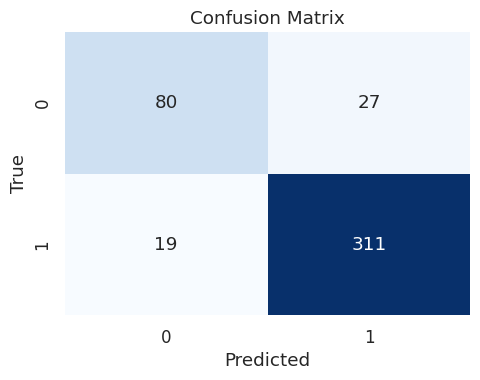

In [52]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Refit scaler on augmented data
scaler = StandardScaler()
X_aug_scaled = scaler.fit_transform(X_aug)
X_test_scaled = scaler.transform(X_test)  # Test stays unchanged

# Fit voting model on augmented data
voting_model.fit(X_aug_scaled, y_aug)

# Predict on original test set
y_pred = voting_model.predict(X_test_scaled)
y_proba = voting_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\n📊 Weighted Soft Voting Ensemble Results (Trained on Augmented Data):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [53]:
# Scale the augmented data
scaler = StandardScaler()
X_aug_scaled = scaler.fit_transform(X_aug)
# Fit final ensemble on full augmented & scaled data
voting_model.fit(X_aug_scaled, y_aug)
final_model = voting_model


In [54]:
from sklearn.impute import KNNImputer

# 1. Select all numerical columns (before any transformation)
fe_df_raw = fe_df[numerical_columns].copy()
test_df_raw = test_df[numerical_columns].copy()

# 2. Fit KNN imputer on the training data
knn_imputer = KNNImputer(n_neighbors=5)
fe_df_imputed = pd.DataFrame(knn_imputer.fit_transform(fe_df_raw), columns=fe_df_raw.columns)
test_df_imputed = pd.DataFrame(knn_imputer.transform(test_df_raw), columns=test_df_raw.columns)

# 3. Replace the original numerical columns in fe_df and test_df
fe_df[numerical_columns] = fe_df_imputed
test_df[numerical_columns] = test_df_imputed

# Reapply transformations (cyclical + temp diff + RBFs)
test_df["day_sin"] = np.sin(2 * np.pi * test_df["day"] / 365)
test_df["day_cos"] = np.cos(2 * np.pi * test_df["day"] / 365)
test_df["TempDiff"] = test_df["maxtemp"] - test_df["mintemp"]

for mu, sigma in zip(mu_list, sigma_list):
    col_name = f"rbf_{mu}_{sigma}"
    test_df[col_name] = np.exp(- (test_df["winddirection"] - mu)**2 / (2 * sigma**2))

# Subset and scale
X_test = test_df[columns_to_use].copy()
X_test_scaled = scaler.transform(X_test)

In [55]:
y_pred = final_model.predict(X_test_scaled)

In [56]:
# Make predictions on the test set
test_predictions = final_model.predict(X_test_scaled)

# Prepare submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'Premium Amount': test_predictions
})
submission.to_csv("submission.csv", index=False)
